# Import libraries

In [285]:
from requests_html import HTMLSession
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
%matplotlib inline

In [286]:
from stop_words import get_stop_words
stop_words = get_stop_words('italian')
stop_words.append('titolo')

In [287]:
pd.set_option('display.max_colwidth', 150)

In [288]:
session = HTMLSession()

# Scrape 'La Repubblica'

In [289]:
url_rep = 'https://ricerca.repubblica.it/ricerca/repubblica?ref=HRHS&query=elezioni&filter_type=articolo&page=2'
r_rep = session.get(url_rep)
r_rep.status_code

200

In [290]:
def scrape_rep(url):
    
    '''Scrapes "La Repubblica", search page and returns Title'''
    r = session.get(url)
    parsed_html = r.html
    article_info = parsed_html.find('''[title="Leggi l'articolo"]''')
    article_list = []
    for article in article_info:
        article_list.append(article.text)
        
    article_df = pd.DataFrame(article_list)
    return article_df

In [291]:
def search_rep(searchterm, pages):
    '''Scrapes Titles from "La Repubblica"'''
    
    results_dfs = []
    for page in range(1,pages+1):
        url = 'https://ricerca.repubblica.it/ricerca/repubblica?ref=HRHS&query=' + searchterm + '&filter_type=articolo&page=' + str(page)
        df = scrape_rep(url)
        results_dfs.append(df)
    results_dfs = pd.concat(results_dfs)
    return results_dfs

In [292]:
test_rep = search_rep('elezioni', 4)

# Scrape 'La Stampa'

In [293]:
url_st = 'https://www.lastampa.it/ricerca?search=elezioni%20AND%20sections:italia/cronache*%20&pagina=3'
r_st = session.get(url_st)
r_st.status_code

200

In [294]:
def scrape_stampa(url):
    
    '''Scrapes "La Stampa", search page and returns Title'''
    r = session.get(url)
    parsed_html = r.html
    article_info = parsed_html.find('.titolo')
    article_list = []
    for article in article_info:
        article_list.append(article.text)
        
    article_df = pd.DataFrame(article_list)
    return article_df

In [295]:
def search_stampa(searchterm, pages):
    '''Scrapes Titles from "La Stampa"'''
    
    results_dfs = []
    for page in range(1,pages+1):
        url = 'https://www.lastampa.it/ricerca?search=' + searchterm + '%20AND%20sections:italia/cronache*%20&pagina=' + str(page)
        df = scrape_stampa(url)
        results_dfs.append(df)
    results_dfs = pd.concat(results_dfs)
    return results_dfs

In [296]:
test_st = search_stampa('voto', 3)

# Scrape 'Il Mattino'

In [297]:
url_mat = 'https://www.ilmattino.it/home_page.php?p=search&q=europa&start=80'
r_mat = session.get(url_mat)
r_mat.status_code

200

In [298]:
def scrape_ilmattino(url):
    
    '''Scrapes "Il Mattino", search page and returns URLs and Title'''
    r = session.get(url)
    parsed_html = r.html
    article_info = parsed_html.find('h3')
    article_list = []
    for article in article_info:
        article_list.append(article.text)

        
    article_df = pd.DataFrame(article_list)
    return article_df

In [299]:
def search_matt(searchterm, page):
    '''Searches "Il Mattino". 
       Returns a df of titles'''
    
    results_dfs = []
    
    for page in range(0, page):
       
        url = 'https://www.ilmattino.it/home_page.php?p=search&q=' + searchterm + '&start=' + str(page*40)
        df = scrape_ilmattino(url)
        results_dfs.append(df)
    result_df = pd.concat(results_dfs)
    return result_df

In [300]:
test_mat = search_matt('europa', 2)

# Topic word 1: 'Elezioni'

# a) La Repubblica

In [301]:
elections_rep = search_rep('elezioni', 100)

In [302]:
elections_rep.head()

,0
0,no titolo
1,no titolo
2,"Elezioni, se decidono gli indecisi"
3,no titolo
4,no titolo


In [303]:
elections_rep.tail()

,0
6,"In piazza per protestare contro il successore di Bouteflika: "" Vattene"""
7,"Giurlani, maxirisarcimento per i contributi mai versati"
8,"MERKEL-MACRON, CRISI DI COPPIA"
9,Mattarella: la Ue sarà più forte dei sovranisti Sui migranti serve unità
10,"Cucinotta, Belvedere e Andreozzi "" figlie di Eva"""


In [304]:
elections_rep.describe()

,0
count,1074
unique,908
top,
freq,77


In [305]:
elections_rep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1074 entries, 0 to 10
Data columns (total 1 columns):
0    1074 non-null object
dtypes: object(1)
memory usage: 16.8+ KB


In [306]:
elections_rep = elections_rep.rename(columns = {0:"Titles"})

In [307]:
%matplotlib inline

In [308]:
def word_count(text_string):
    '''Calculate the length of a string, removing em-dashes.'''
    return len(text_string.split())
    edited_text_string = text_string.replace('—', '')
    return len(edited_text_string.split())

In [309]:
elections_rep['word_numb'] = elections_rep['Titles'].apply(word_count)

In [310]:
elections_rep['word_numb'].describe()

count    1074.000000
mean        7.592179
std         4.286498
min         0.000000
25%         4.000000
50%         8.000000
75%        11.000000
max        21.000000
Name: word_numb, dtype: float64

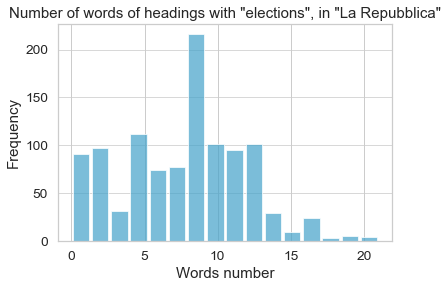

In [311]:
n, bins, patches = plt.hist(x=elections_rep['word_numb'], bins='auto', color='#43a2ca',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Words number')
plt.ylabel('Frequency')
plt.title('''Number of words of headings with "elections", in "La Repubblica"''')
maxfreq = n.max()

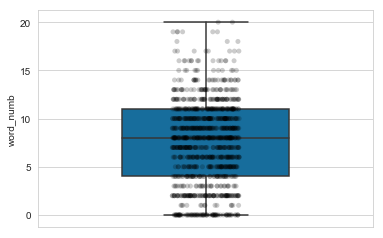

In [28]:
sns.boxplot(y = 'word_numb', 
                 data = elections_rep, 
                 width=0.5,
                 palette="colorblind")
sns.stripplot(y = 'word_numb', 
                   data = elections_rep, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

Word count, using Vectorizer

In [240]:
vectorizer_el_rep = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             ngram_range = (1,2),
                             max_df    = 0.99,
                             min_df    = 0.01)

In [241]:
vectorizer_el_rep.fit(elections_rep['Titles'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=0.01,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [242]:
len(vectorizer_el_rep.get_feature_names())

35

In [243]:
vectorizer_el_rep.get_feature_names()[0:10]

['campagna',
 'candidati',
 'comune',
 'corsa',
 'così',
 'destra',
 'dopo',
 'elettorale',
 'elezioni',
 'elezioni europee']

In [244]:
frequency_el_rep = vectorizer_el_rep.transform(elections_rep['Titles'])

In [245]:
frequency_el_rep

<1073x35 sparse matrix of type '<class 'numpy.int64'>'
	with 861 stored elements in Compressed Sparse Row format>

In [231]:
wordfreq_el_rep = pd.DataFrame(frequency_el_rep.toarray(),
                            columns = vectorizer_el_rep.get_feature_names(),
                            index = elections_rep.index)

In [232]:
wordfreq_el_rep.head()

,candidati,elezioni,europa,europee,italia,lega,pd,rai,salvini,sinistra,voto,zingaretti
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0


In [233]:
wordfreq_el_rep.tail()

,candidati,elezioni,europa,europee,italia,lega,pd,rai,salvini,sinistra,voto,zingaretti
8,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0,0


In [234]:
wordfreq_el_rep.sum().sort_values(ascending=False)[:20]

elezioni      102
europee        63
pd             58
europa         57
salvini        47
voto           39
lega           36
italia         32
zingaretti     27
sinistra       26
candidati      23
rai            22
dtype: int64

In [235]:
df_freq_el_rep = wordfreq_el_rep.sum().sort_values(ascending=False)[:20]

In [236]:
pd.DataFrame(df_freq_el_rep)

,0
elezioni,102
europee,63
pd,58
europa,57
salvini,47
voto,39
lega,36
italia,32
zingaretti,27
sinistra,26


In [237]:
df_freq_el_rep.to_csv('freq_el_rep.csv')

In [238]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=45, fontsize = 18) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

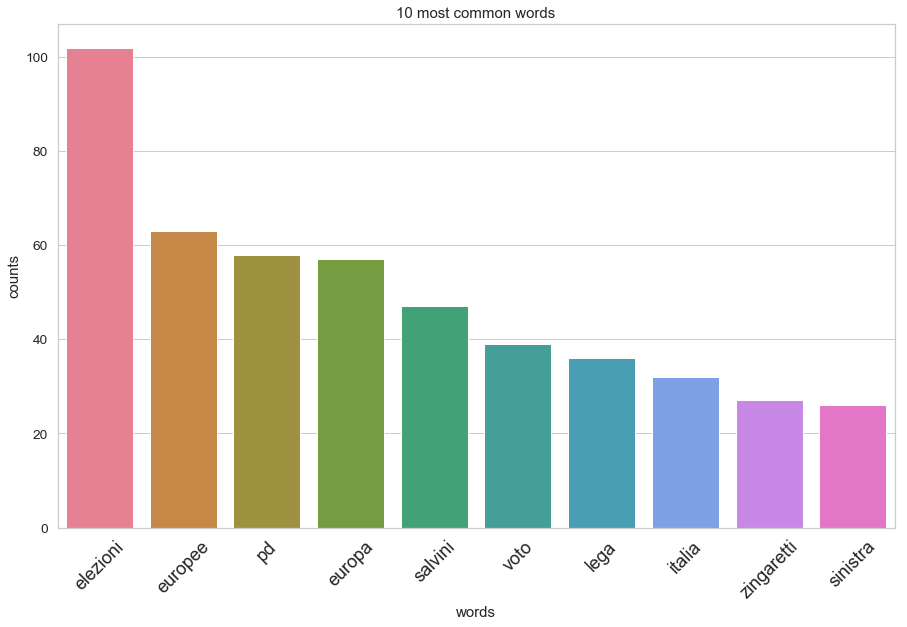

In [239]:
plot_10_most_common_words(frequency_el_rep, vectorizer_el_rep)

Latent Dirichlet Allocation

In [41]:
def best_groups(groups):
    'Looks for the number of groups that gives the best combination of Log Likelihood and Perplexity'
    models = []

    for model in range(1,groups+1):
        lda_model_el_rep = LatentDirichletAllocation(n_components = model)
        lda_model_el_rep.fit(frequency_el_rep)
        loglik = lda_model_el_rep.score(frequency_el_rep)
        perpl = lda_model_el_rep.perplexity(frequency_el_rep)
        seq = model
        models_dict = {'Log Likelihood': loglik,
                  'Perplexity': perpl,
                  'Groups': seq}
        models.append(models_dict)
    models_df = pd.DataFrame(models)
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Groups')
    models_df.plot.scatter(y = 'Perplexity', x = 'Groups')
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Perplexity')
    return models_df

,Groups,Log Likelihood,Perplexity
0,1,-2931.446289,29.868641
1,2,-3014.330279,32.879549
2,3,-3069.802186,35.062383
3,4,-3158.958045,38.878370
4,5,-3170.229184,39.389468
5,6,-3164.485143,39.128166
6,7,-3174.687777,39.593496
7,8,-3206.037807,41.058245
8,9,-3214.770805,41.475837
9,10,-3213.734490,41.426061


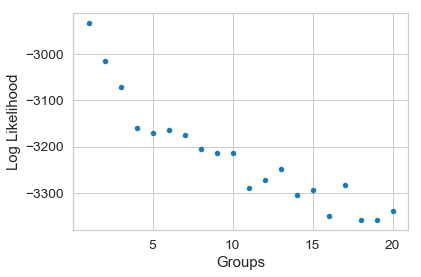

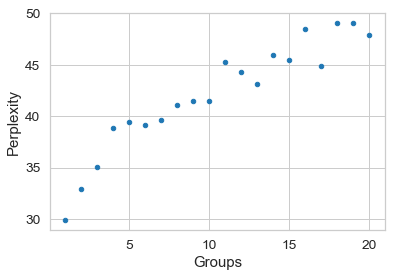

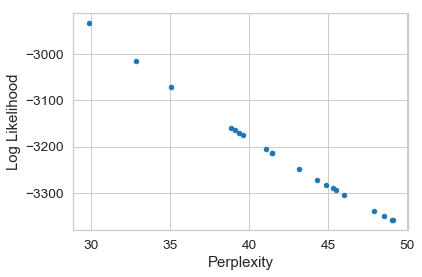

In [42]:
best_groups(20)

In [43]:
lda_model_el_rep = LatentDirichletAllocation(n_components = 6)

In [44]:
lda_model_el_rep.fit(frequency_el_rep)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=6, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [45]:
print("Log Likelihood: ", lda_model_el_rep.score(frequency_el_rep))

print("Perplexity: ", lda_model_el_rep.perplexity(frequency_el_rep))

Log Likelihood:  -3179.340505149029
Perplexity:  39.80753457373386


In [46]:
print(lda_model_el_rep.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 6, 'n_jobs': None, 'n_topics': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [47]:
pyLDAvis.enable_notebook()
panel_el_rep = pyLDAvis.sklearn.prepare(lda_model_el_rep, frequency_el_rep, vectorizer_el_rep, mds='tsne')
panel_el_rep

/Users/federico/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3       -7.960482  -20.271765       1        1  19.835126
2       -1.375653 -196.857620       2        1  19.435609
4     -117.090919  118.710716       3        1  18.102714
0     -173.867859  -81.108681       4        1  15.328233
5       90.499077  126.464714       5        1  14.225427
1      162.016220  -68.574280       6        1  13.072892, topic_info=     Category       Freq              Term      Total  loglift  logprob
term                                                                   
8     Default  97.000000          elezioni  97.000000  30.0000  30.0000
10    Default  55.000000            europa  55.000000  29.0000  29.0000
33    Default  41.000000              voto  41.000000  28.0000  28.0000
11    Default  64.000000           europee  64.000000  27.0000  27.0000
23    Default  54.000000                pd  54.000000  26.0000  26.0000
29    Default  27.000000          sinistra  27.000000  25.0000  25.0000
26    Default  44.000000           salvini  44.000000  24.0000  24.0000
17    Default  33.000000              lega  33.000000  23.0000  23.0000
16    Default  31.000000            italia  31.000000  22.0000  22.0000
25    Default  23.000000               rai  23.000000  21.0000  21.0000
34    Default  25.000000        zingaretti  25.000000  20.0000  20.0000
22    Default  19.000000               ora  19.000000  19.0000  19.0000
1     Default  22.000000         candidati  22.000000  18.0000  18.0000
2     Default  16.000000            comune  16.000000  17.0000  17.0000
4     Default  16.000000              così  16.000000  16.0000  16.0000
15    Default  18.000000           governo  18.000000  15.0000  15.0000
20    Default  18.000000              maio  18.000000  14.0000  14.0000
9     Default  19.000000  elezioni europee  19.000000  13.0000  13.0000
30    Default  16.000000              solo  16.000000  12.0000  12.0000
13    Default  16.000000             forza  16.000000  11.0000  11.0000
0     Default  14.000000          campagna  14.000000  10.0000  10.0000
6     Default  12.000000              dopo  12.000000   9.0000   9.0000
5     Default  15.000000            destra  15.000000   8.0000   8.0000
21    Default  12.000000           milioni  12.000000   7.0000   7.0000
31    Default  15.000000                ue  15.000000   6.0000   6.0000
12    Default  14.000000                fa  14.000000   5.0000   5.0000
28    Default  13.000000           sindaco  13.000000   4.0000   4.0000
7     Default  11.000000        elettorale  11.000000   3.0000   3.0000
14    Default  12.000000      forza italia  12.000000   2.0000   2.0000
19    Default  12.000000            maggio  12.000000   1.0000   1.0000
...       ...        ...               ...        ...      ...      ...
24     Topic6   0.174687          politica  10.891059  -2.0981  -6.4705
7      Topic6   0.174600        elettorale  11.395813  -2.1439  -6.4710
3      Topic6   0.174870             corsa  11.685952  -2.1675  -6.4695
19     Topic6   0.174874            maggio  12.297521  -2.2185  -6.4695
21     Topic6   0.174567           milioni  12.305676  -2.2209  -6.4712
14     Topic6   0.174436      forza italia  12.297438  -2.2210  -6.4720
28     Topic6   0.174603           sindaco  13.241387  -2.2940  -6.4710
27     Topic6   0.174378             sfida  13.979344  -2.3495  -6.4723
0      Topic6   0.174373          campagna  14.239076  -2.3679  -6.4723
32     Topic6   0.174901                va  14.288825  -2.3684  -6.4693
12     Topic6   0.174600                fa  14.498622  -2.3847  -6.4710
18     Topic6   0.174376               m5s  14.962826  -2.4175  -6.4723
5      Topic6   0.174572            destra  15.129199  -2.4274  -6.4712
31     Topic6   0.174376                ue  15.400442  -2.4463  -6.4723
13     Topic6   0.174577             forza  16.073127  -2.4879  -6.4712
30     Topic6   0.174751             

In [48]:
def column_swap(column):
    column = column.sort_values(ascending = False)
    return column.index

In [49]:
def topic_words_df(lda_model, vectorizer):
    '''
    Generate dataframe of words associated with a topic model.
    '''
    
    word_topic_scores = lda_model.components_.T
    vocabulary        = vectorizer.get_feature_names()
    
    
    topic_words_df = pd.DataFrame(word_topic_scores,
                                  index = vocabulary)
    
    topic_words_df = topic_words_df.apply(column_swap).reset_index(drop = True).rename_axis('rank')
    
    topic_words_df.index = topic_words_df.index + 1
    
    return topic_words_df

In [50]:
topic_words_df(lda_model_el_rep, vectorizer_el_rep).head(10)

,0,1,2,3,4,5
rank,,,,,,
1,elezioni,voto,europa,pd,salvini,europee
2,governo,rai,elezioni,lega,italia,sinistra
3,solo,comune,candidati,zingaretti,maio,ora
4,campagna,così,europee,ue,forza,milioni
5,elettorale,dopo,elezioni europee,fa,destra,pd
6,dopo,va,va,politica,sindaco,corsa
7,milioni,candidati,sfida,salvini,forza italia,m5s
8,m5s,maggio,corsa,m5s,maggio,va
9,fa,corsa,italia,sfida,m5s,campagna


In [247]:
topic_words_df(lda_model_el_rep, vectorizer_el_rep).head(10).to_csv('groups_el_rep.csv')

In [51]:
topics_el_rep = lda_model_el_rep.transform(frequency_el_rep)

In [52]:
pd.DataFrame(topics_el_rep).head(10)

,0,1,2,3,4,5
0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
2,0.582944,0.083333,0.083723,0.083333,0.083333,0.083333
3,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
4,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
5,0.582944,0.083333,0.083723,0.083333,0.083333,0.083333
6,0.582944,0.083333,0.083723,0.083333,0.083333,0.083333
7,0.582944,0.083333,0.083723,0.083333,0.083333,0.083333
8,0.033703,0.033333,0.832656,0.033333,0.033333,0.033641
9,0.042315,0.041667,0.791000,0.041667,0.041685,0.041667


In [53]:
spacy.cli.download("it")

✔ Download and installation successful
You can now load the model via spacy.load('it_core_news_sm')
✔ Linking successful
/Users/federico/anaconda3/lib/python3.7/site-packages/it_core_news_sm -->
/Users/federico/anaconda3/lib/python3.7/site-packages/spacy/data/it
You can now load the model via spacy.load('it')


In [54]:
nlp = spacy.load('it')

In [55]:
def extract_adjectives(text):
    adjectives = []
    doc = nlp(text)
    for token in doc:
        if token.pos_ == 'ADJ':
            adjectives.append(token.text)
    adjectives = ', '.join(adjectives)
    return adjectives

In [56]:
elections_rep['Adjectives'] = elections_rep['Titles'].apply(extract_adjectives)

In [57]:
elections_rep['Adjectives']

0                          
1                          
2                          
3                          
4                          
5                          
6              Gran, finale
7                    scambi
8                   europee
9                          
0                      urne
1                   europeo
2                          
3                   europeo
4                          
5                   Europee
6                   europeo
7                   europeo
8                          
9                          
0                          
1                          
2                   europeo
3                          
4              indifferenti
5                          
6                          
7                          
8                   Europee
9                     vuota
              ...          
5                          
6                          
7                sovranista
8                   europee
9                   

In [58]:
vectorizer_el_rep2 = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 1.0,
                             min_df    = 0.0)

In [59]:
vectorizer_el_rep2.fit(elections_rep['Adjectives'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [60]:
wf_el_rep = vectorizer_el_rep2.transform(elections_rep['Adjectives'])

In [61]:
df_el_rep = pd.DataFrame(wf_el_rep.todense(),
                        columns = vectorizer_el_rep2.get_feature_names())

In [62]:
df_el_rep.sum().sort_values(ascending=False)

europee        30
elettorale     11
ex              9
europeo         7
sovranista      7
urne            7
migranti        6
nuovo           6
ultimo          6
anti            6
nuovi           5
destra          5
regionali       5
primo           5
comunali        4
populista       4
antimafia       4
elettorali      4
voto            4
comune          3
sindaca         3
spagnole        3
leghista        3
grillini        3
grandi          3
secondo         3
italiani        3
ultima          3
prime           3
italiana        3
               ..
pericolosa      1
proibito        1
procurarsi      1
precari         1
pre             1
povero          1
potenziali      1
possibile       1
pole            1
pieno           1
piemontese      1
piccoli         1
personali       1
pericolose      1
perfetta        1
neofascista     1
pentiti         1
penale          1
patria          1
palco           1
orfana          1
opposta         1
operaio         1
olimpiche       1
olandese  

In [264]:
df_el_rep.sum().sort_values(ascending=False).to_csv('adj_el_rep.csv')

# b) La Stampa

In [63]:
elections_st = search_stampa('elezioni', 100)

In [64]:
elections_st.head()

,0
0,"Elezioni, ecco gli sconti sul viaggio in treno, aereo, bus e autostrade"
1,"Martina: il Pd va rifondato alla radice, deve rappresentare i lavoratori"
2,"Tra i leghisti nel mito di Alberto da Giussano “Crediamo al primo cittadino, meno ai pm”"
3,"Chi è Giambattista Fratus, il sindaco di Legnano vicino a Salvini"
4,A Roma una fronda contro Pignatone nella guerra di successione in Procura


In [65]:
elections_st.tail()

,0
5,"Festa M5S, palco vietato a Pizzarotti Un piano del Pd per “degrillizzarlo”"
6,"Sospeso De Magistris, elezioni più vicine"
7,L’ex pm non si piega alla giustizia: “Dobbiamo fare resistenza”
8,“La mia nuova vita in Svezia tra gli incubi di quella notte e il rumore della neve sui tetti”
9,De Magistris verso la sospensione: “Ma mi ricandiderò”


In [66]:
elections_st.describe()

,0
count,1000
unique,998
top,A Roma una fronda contro Pignatone nella guerra di successione in Procura
freq,2


In [67]:
elections_st.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 9
Data columns (total 1 columns):
0    1000 non-null object
dtypes: object(1)
memory usage: 15.6+ KB


In [68]:
elections_st = elections_st.rename(columns = {0:"Titles"})

In [69]:
elections_st['word_numb'] = elections_st['Titles'].apply(word_count)

In [70]:
elections_st['word_numb'].describe()

count    1000.000000
mean       11.124000
std         2.899143
min         0.000000
25%         9.000000
50%        11.000000
75%        13.000000
max        24.000000
Name: word_numb, dtype: float64

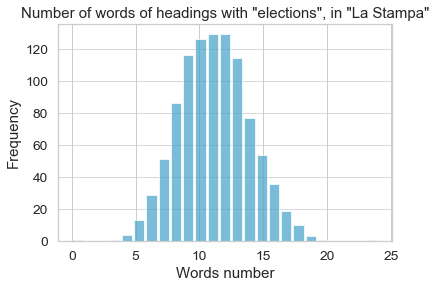

In [71]:
n, bins, patches = plt.hist(x=elections_st['word_numb'], bins=25, color='#43a2ca',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Words number')
plt.ylabel('Frequency')
plt.title('''Number of words of headings with "elections", in "La Stampa"''')
maxfreq = n.max()

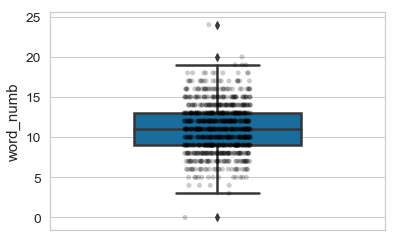

In [72]:
sns.boxplot(y = 'word_numb', 
                 data = elections_st, 
                 width=0.5,
                 palette="colorblind")
sns.stripplot(y = 'word_numb', 
                   data = elections_st, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

In [183]:
vectorizer_el_st = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             ngram_range = (1,2),
                             max_df    = 0.99,
                             min_df    = 0.01)

In [186]:
vectorizer_el_st.fit(elections_st['Titles'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=0.01,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [187]:
vectorizer_el_st.get_feature_names()[0:10]

['alema',
 'alfano',
 'anni',
 'anti',
 'arrestato',
 'basta',
 'berlusconi',
 'candidato',
 'capitale',
 'centrodestra']

In [188]:
frequency_el_st = vectorizer_el_st.transform(elections_st['Titles'])

In [189]:
frequency_el_st

<1000x80 sparse matrix of type '<class 'numpy.int64'>'
	with 1623 stored elements in Compressed Sparse Row format>

In [190]:
wordfreq_el_st = pd.DataFrame(frequency_el_st.toarray(),
                            columns = vectorizer_el_st.get_feature_names(),
                            index = elections_st.index)

In [191]:
wordfreq_el_st.head()

,alema,alfano,anni,anti,arrestato,basta,berlusconi,candidato,capitale,centrodestra,...,sud,sì,ue,urne,va,verso,via,voti,voto,vuole
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [192]:
wordfreq_el_st.tail()

,alema,alfano,anni,anti,arrestato,basta,berlusconi,candidato,capitale,centrodestra,...,sud,sì,ue,urne,va,verso,via,voti,voto,vuole
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [193]:
wordfreq_el_st.sum().sort_values(ascending=False)[:20]

pd            83
renzi         75
italia        63
berlusconi    60
voto          53
salvini       49
roma          44
governo       43
elezioni      35
m5s           35
ora           35
ex            30
così          28
sindaco       27
lega          27
maio          26
forza         25
partito       25
gentiloni     24
anni          22
dtype: int64

In [194]:
df_freq_el_st = wordfreq_el_st.sum().sort_values(ascending=False)[:20]

In [195]:
pd.DataFrame(df_freq_el_st)

,0
pd,83
renzi,75
italia,63
berlusconi,60
voto,53
salvini,49
roma,44
governo,43
elezioni,35
m5s,35


In [196]:
df_freq_el_st.to_csv('freq_el_st.csv')

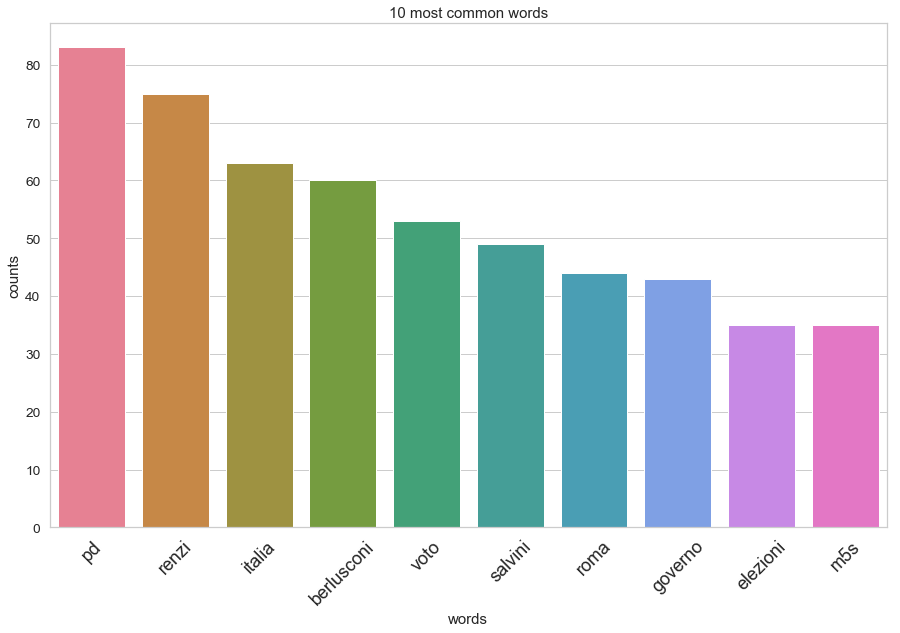

In [197]:
plot_10_most_common_words(frequency_el_st, vectorizer_el_st)

Latent Dirichlet Allocation

In [83]:
def best_groups(groups):
    'Looks for the number of groups that gives the best combination of Log Likelihood and Perplexity'
    models = []

    for model in range(1,groups+1):
        lda_model_el_st = LatentDirichletAllocation(n_components = model)
        lda_model_el_st.fit(frequency_el_st)
        loglik = lda_model_el_st.score(frequency_el_st)
        perpl = lda_model_el_st.perplexity(frequency_el_st)
        seq = model
        models_dict = {'Log Likelihood': loglik,
                  'Perplexity': perpl,
                  'Groups': seq}
        models.append(models_dict)
    models_df = pd.DataFrame(models)
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Groups')
    models_df.plot.scatter(y = 'Perplexity', x = 'Groups')
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Perplexity')
    return models_df

,Groups,Log Likelihood,Perplexity
0,1,-6932.287417,71.425139
1,2,-7110.736429,79.720940
2,3,-7272.696464,88.081398
3,4,-7330.354041,91.264766
4,5,-7381.375375,94.177555
5,6,-7510.551164,101.974586
6,7,-7501.300748,101.395383
7,8,-7571.669725,105.885488
8,9,-7535.414192,103.547803
9,10,-7560.098411,105.133715


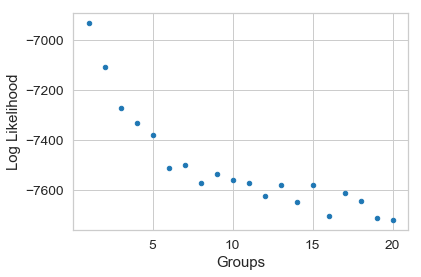

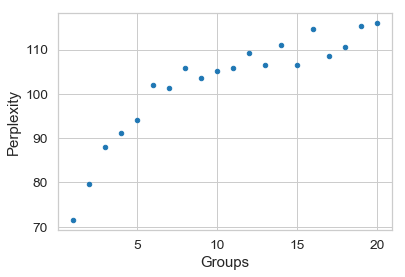

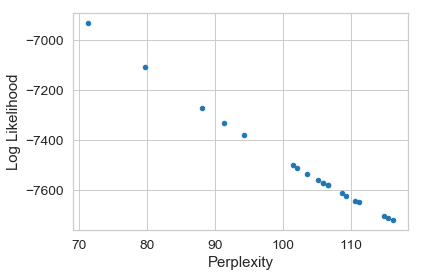

In [84]:
best_groups(20)

In [252]:
lda_model_el_st = LatentDirichletAllocation(n_components = 3)

In [253]:
lda_model_el_st.fit(frequency_el_st)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [254]:
print("Log Likelihood: ", lda_model_el_st.score(frequency_el_st))

print("Perplexity: ", lda_model_el_st.perplexity(frequency_el_st))

Log Likelihood:  -7272.474859498271
Perplexity:  88.06938004810613


In [255]:
pyLDAvis.enable_notebook()
panel_el_st = pyLDAvis.sklearn.prepare(lda_model_el_st, frequency_el_st, vectorizer_el_st, mds='tsne')
panel_el_st

/Users/federico/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
1      -632.045471 -384.325073       1        1  34.957948
0     -1209.665405  212.164124       2        1  32.745353
2     -1437.453247 -586.322510       3        1  32.296699, topic_info=     Category       Freq          Term      Total  loglift  logprob
term                                                               
44    Default  78.000000            pd  78.000000  30.0000  30.0000
55    Default  71.000000         renzi  71.000000  29.0000  29.0000
26    Default  62.000000        italia  62.000000  28.0000  28.0000
58    Default  48.000000       salvini  48.000000  27.0000  27.0000
78    Default  50.000000          voto  50.000000  26.0000  26.0000
57    Default  42.000000          roma  42.000000  25.0000  25.0000
23    Default  41.000000       governo  41.000000  24.0000  24.0000
15    Default  34.000000      elezioni  34.000000  23.0000  23.0000
39    Default  34.000000           ora  34.000000  22.0000  22.0000
6     Default  57.000000    berlusconi  57.000000  21.0000  21.0000
18    Default  30.000000            ex  30.000000  20.0000  20.0000
63    Default  27.000000       sindaco  27.000000  19.0000  19.0000
31    Default  33.000000           m5s  33.000000  18.0000  18.0000
33    Default  25.000000          maio  25.000000  17.0000  17.0000
20    Default  25.000000         forza  25.000000  16.0000  16.0000
11    Default  27.000000          così  27.000000  15.0000  15.0000
42    Default  24.000000       partito  24.000000  14.0000  14.0000
22    Default  23.000000     gentiloni  23.000000  13.0000  13.0000
21    Default  20.000000  forza italia  20.000000  12.0000  12.0000
2     Default  21.000000          anni  21.000000  11.0000  11.0000
48    Default  19.000000      politica  19.000000  10.0000  10.0000
35    Default  19.000000        matteo  19.000000   9.0000   9.0000
17    Default  17.000000        europa  17.000000   8.0000   8.0000
60    Default  17.000000         sfida  17.000000   7.0000   7.0000
14    Default  17.000000    elettorale  17.000000   6.0000   6.0000
7     Default  16.000000     candidato  16.000000   5.0000   5.0000
13    Default  16.000000           due  16.000000   4.0000   4.0000
79    Default  16.000000         vuole  16.000000   3.0000   3.0000
68    Default  16.000000        stelle  16.000000   2.0000   2.0000
4     Default  16.000000     arrestato  16.000000   1.0000   1.0000
...       ...        ...           ...        ...      ...      ...
23     Topic3  41.220460       governo  41.886929   1.1142  -2.5435
15     Topic3  33.615774      elezioni  34.271303   1.1109  -2.7474
39     Topic3  33.605693           ora  34.271231   1.1106  -2.7477
33     Topic3  25.022307          maio  25.703663   1.1033  -3.0427
22     Topic3  23.146204     gentiloni  23.800043   1.1023  -3.1206
42     Topic3  24.068929       partito  24.751823   1.1022  -3.0815
17     Topic3  16.465328        europa  17.136658   1.0902  -3.4612
60     Topic3  16.463363         sfida  17.136832   1.0901  -3.4613
27     Topic3  13.602245        leader  14.280993   1.0815  -3.6522
79     Topic3  15.412643         vuole  16.184476   1.0813  -3.5273
5      Topic3  13.599558         basta  14.281124   1.0813  -3.6524
46     Topic3  12.662690       pisapia  13.328722   1.0789  -3.7238
41     Topic3  12.637769       partiti  13.328089   1.0770  -3.7258
2      Topic3  20.704102          anni  21.908046   1.0737  -3.2321
72     Topic3  10.745685            ue  11.425093   1.0689  -3.8879
52     Topic3   9.819670       procura  10.473006   1.0658  -3.9781
66     Topic3   9.814729        stadio  10.473348   1.0653  -3.9786
45     Topic3  10.704487        piazza  11.426315   1.0649  -3.8918
3      Topic3  14.107628          anti  15.225123   1.0540  -3.6157
19     Topic3   9.666013       fiducia  10.470465   1.0503  -3.9938
9      Topic3  13.607005  centrodestra  15.254505   1.0159

In [256]:
topic_words_df(lda_model_el_st, vectorizer_el_st).head(10)

,0,1,2
rank,,,
1,italia,pd,roma
2,salvini,renzi,governo
3,ex,voto,elezioni
4,sindaco,berlusconi,ora
5,forza,m5s,maio
6,forza italia,così,partito
7,politica,elettorale,gentiloni
8,matteo,lega,anni
9,candidato,stelle,europa


In [257]:
topic_words_df(lda_model_el_st, vectorizer_el_st).head(10).to_csv('groups_el_st.csv')

In [258]:
topics_el_st = lda_model_el_st.transform(frequency_el_st)

In [259]:
pd.DataFrame(topics_el_st).head(10)

,0,1,2
0,0.166701,0.166699,0.666601
1,0.111184,0.777660,0.111156
2,0.666481,0.166756,0.166763
3,0.777733,0.111131,0.111136
4,0.111158,0.111154,0.777687
5,0.333333,0.333333,0.333333
6,0.203363,0.166782,0.629855
7,0.333333,0.333333,0.333333
8,0.111158,0.111154,0.777687
9,0.167232,0.166721,0.666047


In [92]:
elections_st['Adjectives'] = elections_st['Titles'].apply(extract_adjectives)

In [93]:
elections_st['Adjectives']

0                        aereo
1                             
2                    primo, ai
3                             
4                        nella
5            semplice, precisa
6           migranti, italiani
7                             
8                        nella
9                             
0                    austriaco
1                             
2                             
3       intensiva, intestinale
4                        video
5                             
6                             
7                  cara, della
8    africani, mezza, federale
9                    Verifiche
0               della, maestra
1              vuote, prossimo
2                     Pubblico
3                             
4                             
5                  della, fame
6                      europee
7                             
8                             
9              della, comunale
               ...            
0                       schifo
1       

In [94]:
vectorizer_el_st2 = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 1.0,
                             min_df    = 0.0)

In [95]:
vectorizer_el_st2.fit(elections_st['Adjectives'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [96]:
wf_el_st = vectorizer_el_st2.transform(elections_st['Adjectives'])

In [97]:
df_el_st = pd.DataFrame(wf_el_st.todense(),
                        columns = vectorizer_el_st2.get_feature_names())

In [98]:
df_el_st.sum().sort_values(ascending=False)

ex              30
elettorale      18
anti            14
nuova            7
regionali        7
vero             7
nuovo            7
politica         6
migranti         6
pronti           6
regionale        5
soli             5
sociali          5
civili           5
urne             5
grande           5
elettorali       5
prima            5
doppio           5
comunale         4
giusto           4
voto             4
pronto           4
primo            4
impossibile      4
civile           3
liste            3
possibile        3
camorra          3
sindaca          3
                ..
pugliesi         1
pulci            1
punitia          1
piemontesi       1
piccoli          1
monnezza         1
omosessuali      1
mortale          1
naso             1
nazionali        1
ndrangheta       1
nere             1
neutrale         1
neutre           1
nido             1
notabili         1
note             1
online           1
piccola          1
onorevoli        1
orfana           1
orizzonte   

In [261]:
df_el_st.sum().sort_values(ascending=False).to_csv('adj_el_st.csv')

# c) Il Mattino

In [115]:
elections_mat = search_matt('elezioni', 25)

In [116]:
elections_mat.head()

,0
0,ACCEDI AL MATTINO
1,"Sola e sconfitta: l'addio tra le lacrime della May, la lady di gomma"
2,"Elezioni, l'ultimo duello Salvini-Di Maio: «Lega primo partito», «Ma M5S maggioranza»"
3,"Elezioni europee, i cinque scenari di lunedì"
4,I cinque scenari di lunedì


In [117]:
elections_mat.tail()

,0
44,Tredicenne di origini brasiliane picchiata dalle baby bulle Il raid in un video
45,"Elezioni, ultimo duello Salvini-Di Maio: «Lega prima», «M5S maggioranza»"
46,"Ernesto a Foria, ritorno solidale"
47,"Weekend a Napoli, ecco tutti gli eventi"
48,L'amarcord di Piero Mastroberardino


In [118]:
elections_mat.describe()

,0
count,1225
unique,1004
top,"Weekend a Napoli, ecco tutti gli eventi"
freq,25


In [119]:
elections_mat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1225 entries, 0 to 48
Data columns (total 1 columns):
0    1225 non-null object
dtypes: object(1)
memory usage: 19.1+ KB


In [120]:
elections_mat = elections_mat.rename(columns = {0:"Titles"})

In [121]:
elections_mat['word_numb'] = elections_mat['Titles'].apply(word_count)

In [122]:
elections_mat['word_numb'].describe()

count    1225.000000
mean       10.351020
std         3.178135
min         3.000000
25%         8.000000
50%        10.000000
75%        13.000000
max        24.000000
Name: word_numb, dtype: float64

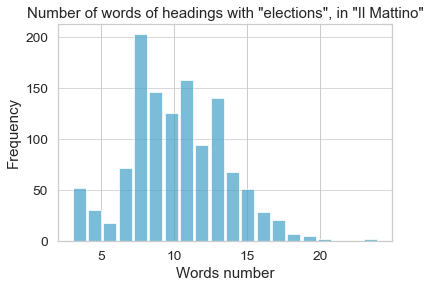

In [123]:
n, bins, patches = plt.hist(x=elections_mat['word_numb'], bins=20, color='#43a2ca',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Words number')
plt.ylabel('Frequency')
plt.title('''Number of words of headings with "elections", in "Il Mattino"''')
maxfreq = n.max()

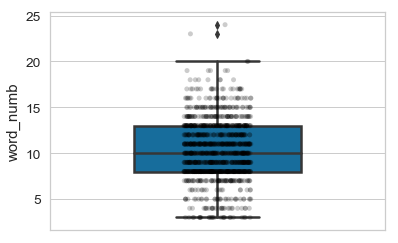

In [124]:
sns.boxplot(y = 'word_numb', 
                 data = elections_mat, 
                 width=0.5,
                 palette="colorblind")
sns.stripplot(y = 'word_numb', 
                   data = elections_mat, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

In [125]:
vectorizer_el_mat = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 0.99,
                             min_df    = 0.01)

In [126]:
vectorizer_el_mat.fit(elections_mat['Titles'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=0.01,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [127]:
len(vectorizer_el_mat.get_feature_names())

92

In [128]:
vectorizer_el_mat.get_feature_names()[0:10]

['10',
 '2019',
 'accedi',
 'addio',
 'amarcord',
 'anni',
 'avellino',
 'avvocati',
 'baby',
 'berlusconi']

In [129]:
frequency_el_mat = vectorizer_el_mat.transform(elections_mat['Titles'])

In [130]:
frequency_el_mat

<1225x92 sparse matrix of type '<class 'numpy.int64'>'
	with 3562 stored elements in Compressed Sparse Row format>

In [131]:
wordfreq_el_mat = pd.DataFrame(frequency_el_mat.toarray(),
                            columns = vectorizer_el_mat.get_feature_names(),
                            index = elections_mat.index)

In [132]:
wordfreq_el_mat.head()

,10,2019,accedi,addio,amarcord,anni,avellino,avvocati,baby,berlusconi,...,treni,tria,ue,ultimo,venezuela,via,video,voto,weekend,zingaretti
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
wordfreq_el_mat.tail()

,10,2019,accedi,addio,amarcord,anni,avellino,avvocati,baby,berlusconi,...,treni,tria,ue,ultimo,venezuela,via,video,voto,weekend,zingaretti
44,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
48,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
wordfreq_el_mat.sum().sort_values(ascending=False)[:20]

elezioni       282
candidati      198
comunali       188
2019           184
liste          153
salvini        129
napoli          92
lega            92
maio            89
m5s             84
europee         78
voto            52
governo         50
italia          43
prima           36
solo            36
pd              36
maggioranza     33
conte           33
giorno          31
dtype: int64

In [167]:
df_freq_el_mat = wordfreq_el_mat.sum().sort_values(ascending=False)[:20]

In [168]:
pd.DataFrame(df_freq_el_mat)

,0
elezioni,282
candidati,198
comunali,188
2019,184
liste,153
salvini,129
napoli,92
lega,92
maio,89
m5s,84


In [169]:
df_freq_el_mat.to_csv('freq_el_mat.csv')

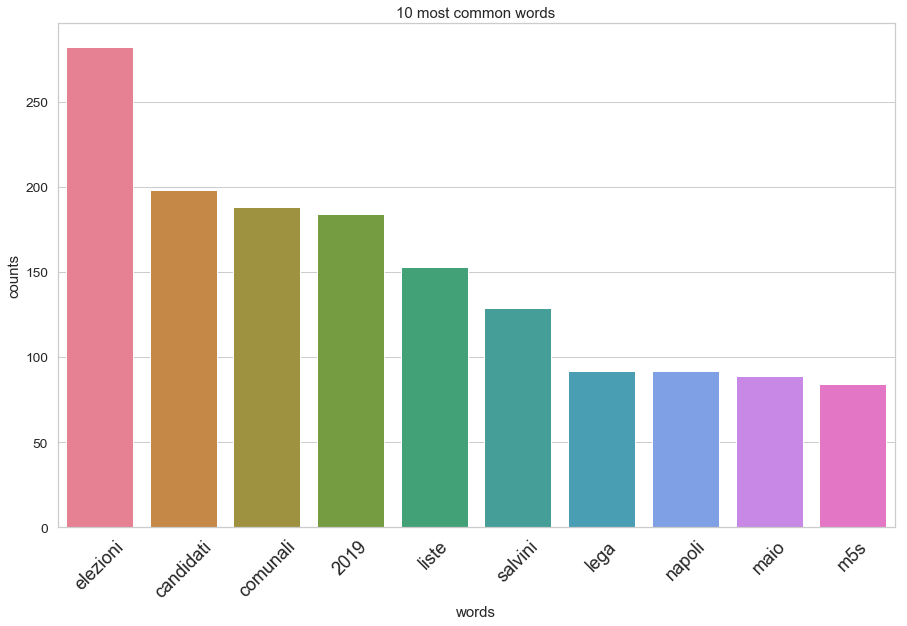

In [160]:
plot_10_most_common_words(frequency_el_mat, vectorizer_el_mat)

Latent Dirichlet Allocation

In [136]:
def best_groups(groups):
    'Looks for the number of groups that gives the best combination of Log Likelihood and Perplexity'
    models = []

    for model in range(1,groups+1):
        lda_model_el_mat = LatentDirichletAllocation(n_components = model)
        lda_model_el_mat.fit(frequency_el_mat)
        loglik = lda_model_el_mat.score(frequency_el_mat)
        perpl = lda_model_el_mat.perplexity(frequency_el_mat)
        seq = model
        models_dict = {'Log Likelihood': loglik,
                  'Perplexity': perpl,
                  'Groups': seq}
        models.append(models_dict)
    models_df = pd.DataFrame(models)
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Groups')
    models_df.plot.scatter(y = 'Perplexity', x = 'Groups')
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Perplexity')
    return models_df

,Groups,Log Likelihood,Perplexity
0,1,-14926.809252,65.905249
1,2,-14390.456154,56.697277
2,3,-13987.623514,50.637781
3,4,-13779.508514,47.765532
4,5,-13756.535342,47.458631
5,6,-13229.689927,40.936996
6,7,-13284.197071,41.567891
7,8,-13054.756095,38.976178
8,9,-13160.242160,40.147024
9,10,-12908.447315,37.408532


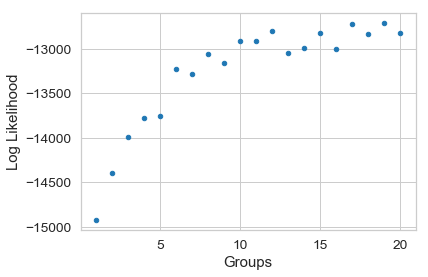

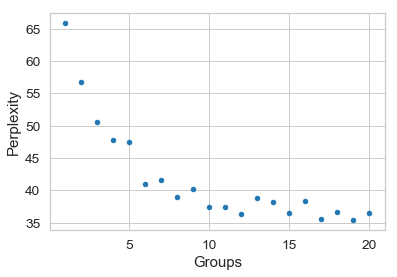

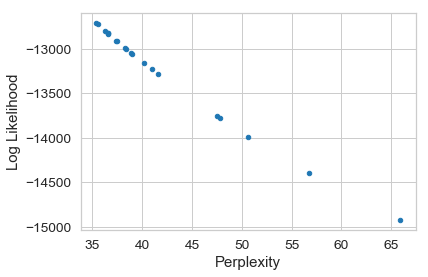

In [137]:
best_groups(20)

In [138]:
lda_model_el_mat = LatentDirichletAllocation(n_components = 5)

In [139]:
lda_model_el_mat.fit(frequency_el_mat)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [140]:
print("Log Likelihood: ", lda_model_el_mat.score(frequency_el_mat))

print("Perplexity: ", lda_model_el_mat.perplexity(frequency_el_mat))

Log Likelihood:  -13348.260242059569
Perplexity:  42.321832947286765


In [141]:
print(lda_model_el_mat.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 5, 'n_jobs': None, 'n_topics': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [142]:
pyLDAvis.enable_notebook()
panel_el_mat = pyLDAvis.sklearn.prepare(lda_model_el_mat, frequency_el_mat, vectorizer_el_mat, mds='tsne')
panel_el_mat

/Users/federico/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      121.554466  211.463730       1        1  29.456928
2      318.252930 -566.593933       2        1  20.509698
0     -457.230255   97.987358       3        1  17.165171
4      646.945068  -53.461193       4        1  16.657710
1     -262.378571 -478.775269       5        1  16.210493, topic_info=     Category        Freq             Term       Total  loglift  logprob
term                                                                    
14    Default  184.000000        candidati  184.000000  30.0000  30.0000
20    Default  175.000000         comunali  175.000000  29.0000  29.0000
1     Default  171.000000             2019  171.000000  28.0000  28.0000
68    Default  124.000000          salvini  124.000000  27.0000  27.0000
29    Default  263.000000         elezioni  263.000000  26.0000  26.0000
43    Default  142.000000            liste  142.000000  25.0000  25.0000
32    Default   79.000000          europee   79.000000  24.0000  24.0000
41    Default   88.000000             lega   88.000000  23.0000  23.0000
46    Default   85.000000             maio   85.000000  22.0000  22.0000
44    Default   81.000000              m5s   81.000000  21.0000  21.0000
52    Default   92.000000           napoli   92.000000  20.0000  20.0000
38    Default   51.000000          governo   51.000000  19.0000  19.0000
39    Default   44.000000           italia   44.000000  18.0000  18.0000
89    Default   50.000000             voto   50.000000  17.0000  17.0000
76    Default   37.000000             solo   37.000000  16.0000  16.0000
59    Default   37.000000               pd   37.000000  15.0000  15.0000
11    Default   32.000000           brexit   32.000000  14.0000  14.0000
24    Default   32.000000               de   32.000000  13.0000  13.0000
37    Default   32.000000           giorno   32.000000  12.0000  12.0000
48    Default   32.000000       mattarella   32.000000  11.0000  11.0000
3     Default   31.000000            addio   31.000000  10.0000  10.0000
66    Default   31.000000             resa   31.000000   9.0000   9.0000
63    Default   35.000000            prima   35.000000   8.0000   8.0000
67    Default   30.000000          ritorno   30.000000   7.0000   7.0000
64    Default   30.000000           pronti   30.000000   6.0000   6.0000
54    Default   30.000000            nuovi   30.000000   5.0000   5.0000
51    Default   30.000000             mesi   30.000000   4.0000   4.0000
42    Default   30.000000            linea   30.000000   3.0000   3.0000
88    Default   29.000000            video   29.000000   2.0000   2.0000
72    Default   29.000000            sette   29.000000   1.0000   1.0000
...       ...         ...              ...         ...      ...      ...
8      Topic5   26.535491             baby   27.318308   1.7904  -3.0806
60     Topic5   25.522831        picchiata   26.305505   1.7893  -3.1196
58     Topic5   25.522831          origini   26.305505   1.7893  -3.1196
81     Topic5   25.522831       tredicenne   26.305505   1.7893  -3.1196
10     Topic5   25.522831       brasiliane   26.305505   1.7893  -3.1196
12     Topic5   25.522831            bulle   26.305505   1.7893  -3.1196
61     Topic5   25.522812            piero   26.305505   1.7893  -3.1196
4      Topic5   25.522812         amarcord   26.305505   1.7893  -3.1196
47     Topic5   25.522812  mastroberardino   26.305505   1.7893  -3.1196
74     Topic5   23.495241          sindaco   24.279790   1.7867  -3.2023
50     Topic5   19.444686              may   20.228606   1.7800  -3.3916
34     Topic5   19.441821               ex   20.228586   1.7798  -3.3917
36     Topic5   18.431608            forza   19.215795   1.7778  -3.4451
80     Topic5   14.379658            torna   15.164539   1.7664  -3.6933
15     Topic5   13.366245        candidato   14.151678   1.7624  -3.7664
78     Topic5    8.996088              sud   16

In [143]:
topic_words_df(lda_model_el_mat, vectorizer_el_mat).head(10)

,0,1,2,3,4
rank,,,,,
1,napoli,italia,salvini,elezioni,europee
2,giorno,brexit,lega,candidati,governo
3,mattarella,de,maio,comunali,solo
4,addio,video,m5s,2019,pd
5,resa,raid,elezioni,liste,nuovi
6,ritorno,berlusconi,voto,mattino,pronti
7,sette,baby,prima,napoli,mesi
8,omaggio,tredicenne,maggioranza,weekend,linea
9,italiana,brasiliane,duello,eventi,10


In [250]:
topic_words_df(lda_model_el_mat, vectorizer_el_mat).head(10).to_csv('groups_el_mat.csv')

In [144]:
topics_el_mat = lda_model_el_mat.transform(frequency_el_mat)

In [145]:
pd.DataFrame(topics_el_mat).head(10)

,0,1,2,3,4
0,0.066667,0.066667,0.066667,0.733331,0.066667
1,0.400026,0.399972,0.066667,0.066667,0.066668
2,0.022222,0.022222,0.910908,0.022425,0.022222
3,0.066667,0.066667,0.067620,0.399043,0.400003
4,0.200000,0.200000,0.200000,0.200000,0.200000
5,0.066667,0.066667,0.733332,0.066667,0.066667
6,0.200000,0.200000,0.200000,0.200000,0.200000
7,0.599217,0.100000,0.100000,0.100782,0.100000
8,0.050001,0.050001,0.347304,0.502694,0.050001
9,0.100000,0.599998,0.100000,0.100000,0.100001


In [146]:
elections_mat['Adjectives'] = elections_mat['Titles'].apply(extract_adjectives)

In [147]:
elections_mat['Adjectives']

0                                         AL
1                     Sola, sconfitta, della
2                              ultimo, primo
3                                    europee
4                                           
5                                      vinco
6                                           
7                                        nei
8     campano, libera, dal, direttivo, della
9                                           
10                                          
11                                elettorale
12                     comune, camorristiche
13                                    Grande
14              dimenticato, della, politica
15                            Europee, primi
16                                   Europee
17                                    giusta
18                                     primo
19                   Europee, impresentabili
20                                          
21                                   camorra
22        

In [148]:
vectorizer_el_mat2 = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 1.0,
                             min_df    = 0.0)

In [149]:
vectorizer_el_mat2.fit(elections_mat['Adjectives'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [150]:
wf_el_mat = vectorizer_el_mat2.transform(elections_mat['Adjectives'])

In [151]:
df_el_mat = pd.DataFrame(wf_el_mat.todense(),
                        columns = vectorizer_el_mat2.get_feature_names())

In [152]:
df_el_mat.sum().sort_values(ascending=False)

comunali        180
europee          32
ultimo           30
nuovi            29
pronti           29
italiana         26
solidale         26
bulle            25
brasiliane       25
nuovo            25
ex               19
elettorale       10
anti              9
primo             8
regionali         8
pronto            7
grande            7
urne              7
leghista          6
libera            6
doppio            5
alta              5
prima             5
politica          5
pronta            5
social            5
nuova             4
migranti          4
legittima         4
elettorali        4
               ... 
polemiche         1
politiche         1
post              1
pratica           1
preoccupata       1
preoccupato       1
primarie          1
prioriaria        1
probabili         1
palco             1
pacifiche         1
pacchetto         1
netto             1
natali            1
necessario        1
negativo          1
nemica            1
neo               1
neomelodica       1


In [263]:
df_el_mat.sum().sort_values(ascending=False).to_csv('adj_el_mat.csv')

# Topic word 2: 'Europa'

# a) La Repubblica

In [312]:
europe_rep = search_rep('Europa', 100)

In [313]:
europe_rep.head()

,0
0,Tutta Europa e mezza Emilia guida al voto che vale doppio
1,Il comizio + Europa in piazza Scala con il bus londinese
2,"Europa, il voto necessario"
3,Evento doppio dal voto in Europa all’America Latina
4,“ Un pubblico da Europa”


In [314]:
europe_rep.tail()

,0
5,Ravenna
6,"""Se Jan Kuciak è un caso risolto lo dobbiamo all’Unione Europea"""
7,"Fca, nel trimestre utile giù del 47% Manley: i target saranno rispettati"
8,Stanlio e Ollio tutti nuovi o il western di Audiard
9,no titolo


In [315]:
europe_rep.describe()

,0
count,1011
unique,800
top,no titolo
freq,71


In [316]:
europe_rep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1011 entries, 0 to 9
Data columns (total 1 columns):
0    1011 non-null object
dtypes: object(1)
memory usage: 15.8+ KB


In [317]:
europe_rep = europe_rep.rename(columns = {0:"Titles"})

In [318]:
europe_rep['word_numb'] = europe_rep['Titles'].apply(word_count)

In [319]:
europe_rep['word_numb'].describe()

count    1011.000000
mean        6.671612
std         4.020858
min         0.000000
25%         3.000000
50%         7.000000
75%         9.000000
max        24.000000
Name: word_numb, dtype: float64

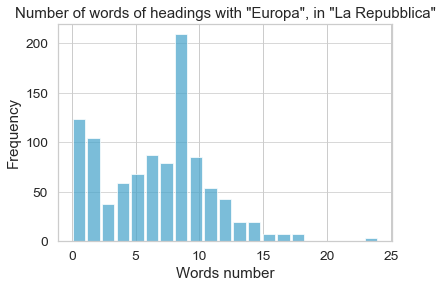

In [320]:
n, bins, patches = plt.hist(x=europe_rep['word_numb'], bins='auto', color='#43a2ca',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Words number')
plt.ylabel('Frequency')
plt.title('''Number of words of headings with "Europa", in "La Repubblica"''')
maxfreq = n.max()

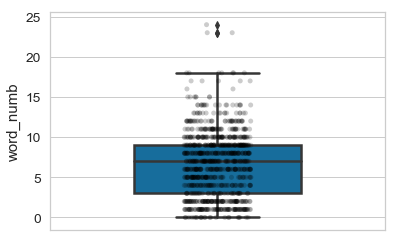

In [321]:
sns.boxplot(y = 'word_numb', 
                 data = europe_rep, 
                 width=0.5,
                 palette="colorblind")
sns.stripplot(y = 'word_numb', 
                   data = europe_rep, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

In [322]:
vectorizer_eu_rep = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             ngram_range = (1,2),
                             max_df    = 0.99,
                             min_df    = 0.01)

In [323]:
vectorizer_eu_rep.fit(europe_rep['Titles'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=0.01,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ..., 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [324]:
len(vectorizer_eu_rep.get_feature_names())

26

In [325]:
vectorizer_eu_rep.get_feature_names()[0:10]

['bologna',
 'catania',
 'città',
 'così',
 'de',
 'due',
 'elezioni',
 'europa',
 'europee',
 'futuro']

In [326]:
frequency_eu_rep = vectorizer_eu_rep.transform(europe_rep['Titles'])

In [327]:
frequency_eu_rep

<1011x26 sparse matrix of type '<class 'numpy.int64'>'
	with 534 stored elements in Compressed Sparse Row format>

In [328]:
wordfreq_eu_rep = pd.DataFrame(frequency_eu_rep.toarray(),
                            columns = vectorizer_eu_rep.get_feature_names(),
                            index = europe_rep.index)

In [329]:
wordfreq_eu_rep.head()

,bologna,catania,città,così,de,due,elezioni,europa,europee,futuro,...,province,ravenna,salvini,serve,sinistra,teatri,ue,unione,voto,zingaretti
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [330]:
wordfreq_eu_rep.tail()

,bologna,catania,città,così,de,due,elezioni,europa,europee,futuro,...,province,ravenna,salvini,serve,sinistra,teatri,ue,unione,voto,zingaretti
5,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [331]:
wordfreq_eu_rep.sum().sort_values(ascending=False)[:20]

europa        175
teatri         24
voto           23
salvini        19
italia         19
bologna        17
europee        17
ora            15
così           15
de             15
lega           15
sinistra       14
città          14
zingaretti     14
pd             13
ravenna        13
ue             13
napoli         12
futuro         12
province       11
dtype: int64

In [428]:
df_freq_eu_rep = wordfreq_eu_rep.sum().sort_values(ascending=False)[:20]

In [429]:
pd.DataFrame(df_freq_eu_rep)

,0
europa,175
teatri,24
voto,23
salvini,19
italia,19
bologna,17
europee,17
ora,15
così,15
de,15


In [430]:
df_freq_eu_rep.to_csv('eu1freq.csv')

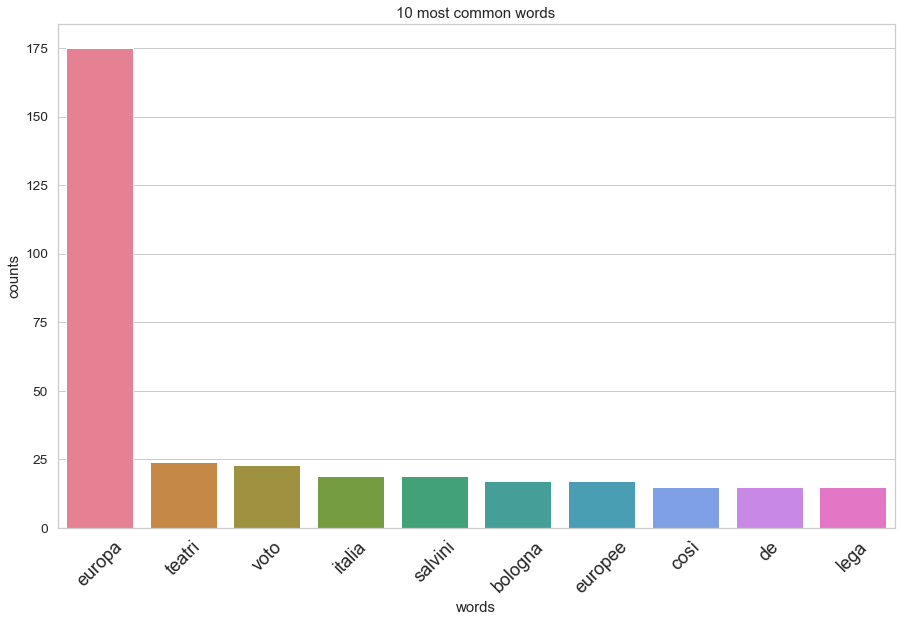

In [332]:
plot_10_most_common_words(frequency_eu_rep, vectorizer_eu_rep)

In [333]:
def best_groups(groups):
    'Looks for the number of groups that gives the best combination of Log Likelihood and Perplexity'
    models = []

    for model in range(1,groups+1):
        lda_model_eu_rep = LatentDirichletAllocation(n_components = model)
        lda_model_eu_rep.fit(frequency_eu_rep)
        loglik = lda_model_eu_rep.score(frequency_eu_rep)
        perpl = lda_model_eu_rep.perplexity(frequency_eu_rep)
        seq = model
        models_dict = {'Log Likelihood': loglik,
                  'Perplexity': perpl,
                  'Groups': seq}
        models.append(models_dict)
    models_df = pd.DataFrame(models)
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Groups')
    models_df.plot.scatter(y = 'Perplexity', x = 'Groups')
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Perplexity')
    return models_df

,Groups,Log Likelihood,Perplexity
0,1,-1534.315272,17.505734
1,2,-1596.761148,19.668768
2,3,-1676.669768,22.830908
3,4,-1707.366650,24.176608
4,5,-1756.215318,26.483479
5,6,-1776.911327,27.526057
6,7,-1750.071375,26.181643
7,8,-1769.706752,27.158544
8,9,-1796.768247,28.564925
9,10,-1836.670307,30.772570


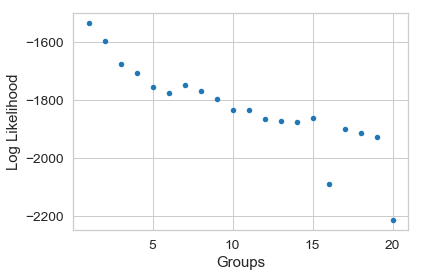

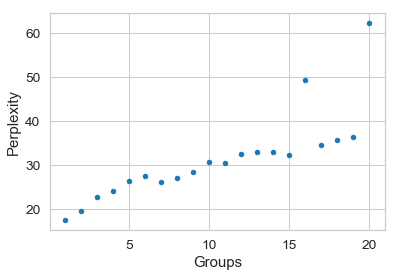

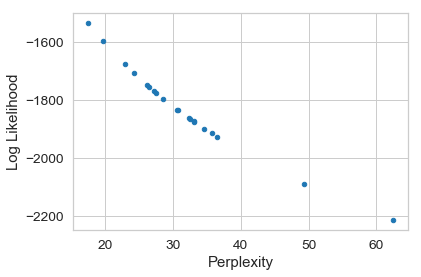

In [334]:
best_groups(20)

In [437]:
lda_model_eu_rep = LatentDirichletAllocation(n_components = 2)

In [438]:
lda_model_eu_rep.fit(frequency_eu_rep)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=2, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [439]:
print("Log Likelihood: ", lda_model_eu_rep.score(frequency_eu_rep))

print("Perplexity: ", lda_model_eu_rep.perplexity(frequency_eu_rep))

Log Likelihood:  -1606.8380902014383
Perplexity:  20.042043815915736


In [440]:
print(lda_model_eu_rep.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 2, 'n_jobs': None, 'n_topics': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [441]:
pyLDAvis.enable_notebook()
panel_eu_rep = pyLDAvis.sklearn.prepare(lda_model_eu_rep, frequency_eu_rep, vectorizer_eu_rep, mds='tsne')
panel_eu_rep

/Users/federico/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
1     -60.312317  141.369629       1        1  55.949046
0      60.312561 -141.369141       2        1  44.050954, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
7     Default  155.000000      europa  155.000000  26.0000  26.0000
21    Default   26.000000      teatri   26.000000  25.0000  25.0000
0     Default   18.000000     bologna   18.000000  24.0000  24.0000
8     Default   18.000000     europee   18.000000  23.0000  23.0000
14    Default   16.000000         ora   16.000000  22.0000  22.0000
12    Default   16.000000        lega   16.000000  21.0000  21.0000
3     Default   16.000000        così   16.000000  20.0000  20.0000
20    Default   15.000000    sinistra   15.000000  19.0000  19.0000
17    Default   14.000000     ravenna   14.000000  18.0000  18.0000
15    Default   14.000000          pd   14.000000  17.0000  17.0000
13    Default   13.000000      napoli   13.000000  16.0000  16.0000
24    Default   21.000000        voto   21.000000  15.0000  15.0000
1     Default   12.000000     catania   12.000000  14.0000  14.0000
16    Default   12.000000    province   12.000000  13.0000  13.0000
11    Default   12.000000      lavoro   12.000000  12.0000  12.0000
6     Default   12.000000    elezioni   12.000000  11.0000  11.0000
19    Default   12.000000       serve   12.000000  10.0000  10.0000
10    Default   17.000000      italia   17.000000   9.0000   9.0000
18    Default   17.000000     salvini   17.000000   8.0000   8.0000
4     Default   14.000000          de   14.000000   7.0000   7.0000
2     Default   13.000000       città   13.000000   6.0000   6.0000
25    Default   13.000000  zingaretti   13.000000   5.0000   5.0000
22    Default   12.000000          ue   12.000000   4.0000   4.0000
9     Default   11.000000      futuro   11.000000   3.0000   3.0000
23    Default   10.000000      unione   10.000000   2.0000   2.0000
5     Default   10.000000         due   10.000000   1.0000   1.0000
7      Topic1  155.248337      europa  155.907184   0.5765  -0.6584
24     Topic1   20.734267        voto   21.345015   0.5517  -2.6716
10     Topic1   17.197102      italia   17.803383   0.5461  -2.8587
18     Topic1   17.191244     salvini   17.804524   0.5457  -2.8590
...       ...         ...         ...         ...      ...      ...
14     Topic1    0.471281         ora   16.831479  -2.9948  -6.4557
8      Topic1    0.469651     europee   18.947210  -3.1167  -6.4592
0      Topic1    0.454488     bologna   18.950164  -3.1497  -6.4920
21     Topic1    0.454472      teatri   26.354113  -3.4795  -6.4920
21     Topic2   25.899642      teatri   26.354113   0.8024  -2.2101
0      Topic2   18.495676     bologna   18.950164   0.7955  -2.5468
8      Topic2   18.477559     europee   18.947210   0.7947  -2.5478
14     Topic2   16.360198         ora   16.831479   0.7914  -2.6695
12     Topic2   16.358306        lega   16.831170   0.7913  -2.6696
3      Topic2   16.332216        così   16.826916   0.7900  -2.6712
20     Topic2   15.293945    sinistra   15.772379   0.7890  -2.7369
17     Topic2   14.264830     ravenna   14.719335   0.7885  -2.8065
13     Topic2   13.186638      napoli   13.658288   0.7847  -2.8851
15     Topic2   14.190714          pd   14.707249   0.7841  -2.8117
1      Topic2   12.149401     catania   12.603919   0.7831  -2.9670
16     Topic2   12.149401    province   12.603919   0.7831  -2.9670
11     Topic2   12.130208      lavoro   12.600789   0.7818  -2.9686
6      Topic2   12.116725    elezioni   12.598590   0.7808  -2.9697
19     Topic2   12.042033       serve   12.586410   0.7756  -2.9759
5      Topic2    0.586196         due   10.718301  -2.0862  -5.9984
23     Topic2    0.574014      unione   10.716315  -2.1070  -6.0194
22     Topic2    0.628952          ue   12.495725  -2.169

In [442]:
topic_words_df(lda_model_eu_rep, vectorizer_eu_rep).head(10)

,0,1
rank,,
1,teatri,europa
2,bologna,voto
3,europee,italia
4,ora,salvini
5,lega,de
6,così,città
7,sinistra,zingaretti
8,ravenna,ue
9,pd,futuro


In [445]:
df_lda_rep = topic_words_df(lda_model_eu_rep, vectorizer_eu_rep).head(10)

In [446]:
pd.DataFrame(df_lda_rep)

,0,1
rank,,
1,teatri,europa
2,bologna,voto
3,europee,italia
4,ora,salvini
5,lega,de
6,così,città
7,sinistra,zingaretti
8,ravenna,ue
9,pd,futuro


In [447]:
df_lda_rep.to_csv('ldarep.csv')

In [443]:
topics_eu_rep = lda_model_eu_rep.transform(frequency_eu_rep)

In [444]:
pd.DataFrame(topics_eu_rep).head(10)

,0,1
0,0.167017,0.832983
1,0.250137,0.749863
2,0.167017,0.832983
3,0.167017,0.832983
4,0.250137,0.749863
5,0.250137,0.749863
6,0.250137,0.749863
7,0.250137,0.749863
8,0.167296,0.832704
9,0.250137,0.749863


In [343]:
europe_rep['Adjectives'] = europe_rep['Titles'].apply(extract_adjectives)

In [344]:
europe_rep['Adjectives']

0              mezza, doppio
1                  londinese
2                 necessario
3               doppio, voto
4                           
5                           
6                           
7                     ostile
8                           
9                     quinta
0                       urne
1                           
2                       urne
3                           
4                           
5                           
6                           
7                     freddo
8                       vero
9                           
0                           
1                           
2                           
3                           
4             forti, fragile
5                           
6                     comune
7                           
8                           
9                           
               ...          
1       high, della, cocaina
2                           
3                      umani
4             

In [345]:
vectorizer_eu_rep2 = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 1.0,
                             min_df    = 0.0)

In [346]:
vectorizer_eu_rep2.fit(europe_rep['Adjectives'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ..., 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [347]:
wf_eu_rep = vectorizer_eu_rep2.transform(europe_rep['Adjectives'])

In [348]:
df_eu_rep = pd.DataFrame(wf_eu_rep.todense(),
                        columns = vectorizer_eu_rep2.get_feature_names())

In [349]:
df_eu_rep.sum().sort_values(ascending=False)

europee            8
nuovo              8
grande             7
finale             6
urne               6
doppio             6
ultimo             5
ultima             5
forti              5
ex                 5
verde              5
nuova              4
sovranista         4
altra              4
prima              4
europeo            4
azzurro            3
unica              3
migranti           3
social             3
primo              3
pronta             3
anti               3
vera               3
italiano           3
italiani           3
post               2
elettorale         2
piccola            2
giovani            2
                  ..
marcio             1
media              1
medievale          1
mediocre           1
populista          1
popolari           1
politici           1
pole               1
pieno              1
perse              1
pagelle            1
ostili             1
ostile             1
onorato            1
olimpico           1
negoziabili        1
negativa     

In [481]:
df_adjrep = df_eu_rep.sum().sort_values(ascending=False)

In [482]:
pd.DataFrame(df_adjrep)

,0
europee,8
nuovo,8
grande,7
finale,6
urne,6
doppio,6
ultimo,5
ultima,5
forti,5
ex,5


In [483]:
df_adjrep.to_csv('eu_ajdrep.csv')

# b) La Stampa

In [350]:
europe_st = search_stampa('Europa', 100)

In [351]:
europe_st.head()

,0
0,"Europa, la posta in palio"
1,"Elezioni, ecco gli sconti sul viaggio in treno, aereo, bus e autostrade"
2,"Ecco il tunnel sottomarino lungo 5 km nel Mar del Nord, nel progetto c’è un’italiana"
3,"Torna il maltempo con pioggia, grandine e vento. E la prossima settimana arriva un ciclone polare"
4,"Bus di turisti si ribalta vicino a Siena, una donna morta e 37 feriti"


In [352]:
europe_st.tail()

,0
5,"Cadono i santuari del Novecento, gli elettori ormai lo fanno strano"
6,Roma batte Bruxelles nella guerra delle vongole
7,La nuova vita del vino d’antan vietato dal Duce
8,Crescono i malumori all’interno del Pd
9,L’università in declino: studenti in fuga e tasse sempre più alte


In [353]:
europe_st.describe()

,0
count,1000
unique,997
top,"Sulla portaerei Garibaldi fra trofie, bandiere e Lancieri di Montebello"
freq,2


In [354]:
europe_st.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 9
Data columns (total 1 columns):
0    1000 non-null object
dtypes: object(1)
memory usage: 15.6+ KB


In [355]:
europe_st = europe_st.rename(columns = {0:"Titles"})

In [356]:
europe_st['word_numb'] = europe_st['Titles'].apply(word_count)

In [357]:
europe_st['word_numb'].describe()

count    1000.000000
mean       11.093000
std         3.013209
min         3.000000
25%         9.000000
50%        11.000000
75%        13.000000
max        24.000000
Name: word_numb, dtype: float64

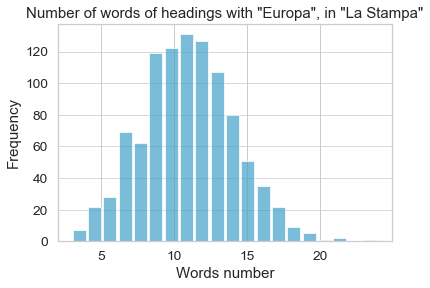

In [358]:
n, bins, patches = plt.hist(x=europe_st['word_numb'], bins=20, color='#43a2ca',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Words number')
plt.ylabel('Frequency')
plt.title('''Number of words of headings with "Europa", in "La Stampa"''')
maxfreq = n.max()

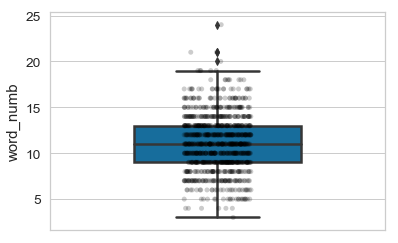

In [359]:
sns.boxplot(y = 'word_numb', 
                 data = europe_st, 
                 width=0.5,
                 palette="colorblind")
sns.stripplot(y = 'word_numb', 
                   data = europe_st, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

In [360]:
vectorizer_eu_st = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             ngram_range = (1,2),
                             max_df    = 0.99,
                             min_df    = 0.01)

In [361]:
vectorizer_eu_st.fit(europe_st['Titles'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=0.01,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ..., 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [362]:
vectorizer_eu_st.get_feature_names()[0:10]

['40',
 '50',
 'allarme',
 'anni',
 'anno',
 'arresti',
 'arriva',
 'bambini',
 'battaglia',
 'bruxelles']

In [363]:
frequency_eu_st = vectorizer_eu_st.transform(europe_st['Titles'])

In [364]:
frequency_eu_st

<1000x64 sparse matrix of type '<class 'numpy.int64'>'
	with 1206 stored elements in Compressed Sparse Row format>

In [365]:
wordfreq_eu_st = pd.DataFrame(frequency_eu_st.toarray(),
                            columns = vectorizer_eu_st.get_feature_names(),
                            index = europe_st.index)

In [366]:
wordfreq_eu_st.head()

,40,50,allarme,anni,anno,arresti,arriva,bambini,battaglia,bruxelles,...,sea watch,sempre,solo,stato,sud,sì,tre,ue,via,watch
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [367]:
wordfreq_eu_st.tail()

,40,50,allarme,anni,anno,arresti,arriva,bambini,battaglia,bruxelles,...,sea watch,sempre,solo,stato,sud,sì,tre,ue,via,watch
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [368]:
wordfreq_eu_st.sum().sort_values(ascending=False)[:20]

italia      139
europa       82
migranti     66
ue           42
così         39
roma         36
anni         28
italiani     26
milano       24
nord         24
salvini      24
governo      23
ora          21
due          21
euro         20
anno         18
m5s          18
record       17
milioni      17
renzi        16
dtype: int64

In [431]:
df_freq_eu_st = wordfreq_eu_st.sum().sort_values(ascending=False)[:20]

In [432]:
pd.DataFrame(df_freq_eu_st)

,0
italia,139
europa,82
migranti,66
ue,42
così,39
roma,36
anni,28
italiani,26
milano,24
nord,24


In [433]:
df_freq_eu_st.to_csv('eu2freq.csv')

plot_10_most_common_words(frequency_eu_st, vectorizer_eu_st)

In [370]:
def best_groups(groups):
    'Looks for the number of groups that gives the best combination of Log Likelihood and Perplexity'
    models = []

    for model in range(1,groups+1):
        lda_model_eu_st = LatentDirichletAllocation(n_components = model)
        lda_model_eu_st.fit(frequency_eu_st)
        loglik = lda_model_eu_st.score(frequency_eu_st)
        perpl = lda_model_eu_st.perplexity(frequency_eu_st)
        seq = model
        models_dict = {'Log Likelihood': loglik,
                  'Perplexity': perpl,
                  'Groups': seq}
        models.append(models_dict)
    models_df = pd.DataFrame(models)
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Groups')
    models_df.plot.scatter(y = 'Perplexity', x = 'Groups')
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Perplexity')
    return models_df

,Groups,Log Likelihood,Perplexity
0,1,-4768.597947,51.806460
1,2,-4917.009198,58.578741
2,3,-5048.145398,65.295839
3,4,-5096.930092,67.986761
4,5,-5160.832273,71.680027
5,6,-5282.475714,79.274012
6,7,-5290.581386,79.807729
7,8,-5258.106466,77.690823
8,9,-5286.849094,79.561532
9,10,-5267.179252,78.276523


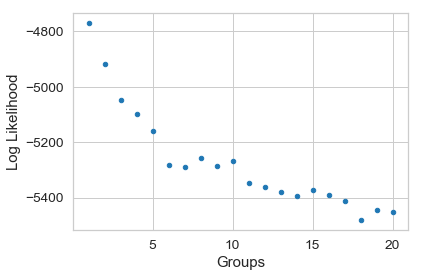

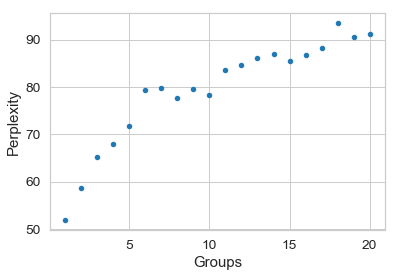

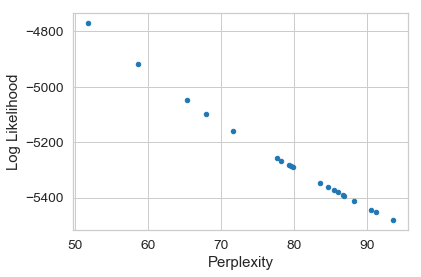

In [371]:
best_groups(20)

In [463]:
lda_model_eu_st = LatentDirichletAllocation(n_components = 5)

In [464]:
lda_model_eu_st.fit(frequency_eu_st)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [465]:
print("Log Likelihood: ", lda_model_eu_st.score(frequency_eu_st))

print("Perplexity: ", lda_model_eu_st.perplexity(frequency_eu_st))

Log Likelihood:  -5141.619626397186
Perplexity:  70.54900944595336


In [466]:
pyLDAvis.enable_notebook()
panel_eu_st = pyLDAvis.sklearn.prepare(lda_model_eu_st, frequency_eu_st, vectorizer_eu_st, mds='tsne')
panel_eu_st

/Users/federico/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      481.255493  306.822784       1        1  21.118184
2      401.173645 -238.585114       2        1  21.047777
1      -50.971565  515.707825       3        1  20.463256
3     -286.260864   17.021603       4        1  19.015701
4      -95.633873 -510.247986       5        1  18.355081, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
24    Default  127.000000     italia  127.000000  30.0000  30.0000
18    Default   78.000000     europa   78.000000  29.0000  29.0000
31    Default   64.000000   migranti   64.000000  28.0000  28.0000
13    Default   39.000000       così   39.000000  27.0000  27.0000
61    Default   38.000000         ue   38.000000  26.0000  26.0000
49    Default   35.000000       roma   35.000000  25.0000  25.0000
3     Default   27.000000       anni   27.000000  24.0000  24.0000
33    Default   23.000000     milano   23.000000  23.0000  23.0000
50    Default   23.000000    salvini   23.000000  22.0000  22.0000
36    Default   23.000000       nord   23.000000  21.0000  21.0000
17    Default   20.000000       euro   20.000000  20.0000  20.0000
4     Default   18.000000       anno   18.000000  19.0000  19.0000
39    Default   19.000000        ora   19.000000  18.0000  18.0000
46    Default   17.000000     record   17.000000  17.0000  17.0000
28    Default   18.000000        m5s   18.000000  16.0000  16.0000
25    Default   26.000000   italiani   26.000000  15.0000  15.0000
34    Default   17.000000    milioni   17.000000  14.0000  14.0000
32    Default   14.000000       mila   14.000000  13.0000  13.0000
41    Default   14.000000      paura   14.000000  12.0000  12.0000
58    Default   15.000000        sud   15.000000  11.0000  11.0000
42    Default   14.000000         pd   14.000000  10.0000  10.0000
23    Default   22.000000    governo   22.000000   9.0000   9.0000
22    Default   13.000000    giovani   13.000000   8.0000   8.0000
16    Default   20.000000        due   20.000000   7.0000   7.0000
37    Default   13.000000      nuova   13.000000   6.0000   6.0000
9     Default   12.000000  bruxelles   12.000000   5.0000   5.0000
5     Default   11.000000    arresti   11.000000   4.0000   4.0000
60    Default   15.000000        tre   15.000000   3.0000   3.0000
2     Default   12.000000    allarme   12.000000   2.0000   2.0000
62    Default   12.000000        via   12.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
25     Topic5   17.480170   italiani   26.455505   1.2809  -2.5404
47     Topic5    5.184849      renzi   16.367528   0.5457  -3.7557
27     Topic5    3.199682     lavoro   10.645759   0.4932  -4.2384
57     Topic5    3.188580      stato   11.528491   0.4100  -4.2419
38     Topic5    2.887588       ogni   10.600371   0.3948  -4.3410
40     Topic5    3.185122      paese   12.044054   0.3652  -4.2430
45     Topic5    2.511623    ragazzi   10.628853   0.2526  -4.4805
16     Topic5    0.569572        due   20.966303  -1.9105  -5.9643
51     Topic5    0.200446    scontro    9.952913  -2.2098  -7.0087
21     Topic5    0.199504  gentiloni    9.952791  -2.2145  -7.0134
0      Topic5    0.200775         40   10.432917  -2.2553  -7.0070
8      Topic5    0.200131  battaglia   10.432877  -2.2585  -7.0102
11     Topic5    0.199978       casa   10.432871  -2.2592  -7.0110
55     Topic5    0.200214     sempre   10.490959  -2.2636  -7.0098
52     Topic5    0.200060     scuola   10.490910  -2.2644  -7.0106
44     Topic5    0.200061      prima   10.491000  -2.2644  -7.0106
12     Topic5    0.200766     centro   10.539501  -2.2655  -7.0071
26     Topic5    0.199501   italiano   10.490993  -2.2672  -7.0134
59     Topic5    0.199494         sì   10.539418  -2.2718  -7.0134
29     Topic5    0.201470       maio   11.498273  -2.3490  -7.0036


In [467]:
topic_words_df(lda_model_eu_st, vectorizer_eu_st).head(10)

,0,1,2,3,4
rank,,,,,
1,migranti,italia,europa,roma,così
2,salvini,ue,italia,milano,euro
3,nord,ora,anni,m5s,anno
4,governo,pd,milioni,due,italiani
5,sud,nuova,renzi,giovani,record
6,via,allarme,fa,tre,mila
7,caccia,dopo,casa,bruxelles,paura
8,maio,gentiloni,40,solo,arresti
9,sea,scontro,battaglia,arriva,rischio


In [469]:
df_lda_st = topic_words_df(lda_model_eu_st, vectorizer_eu_st).head(10)

In [470]:
pd.DataFrame(df_lda_st)

,0,1,2,3,4
rank,,,,,
1,migranti,italia,europa,roma,così
2,salvini,ue,italia,milano,euro
3,nord,ora,anni,m5s,anno
4,governo,pd,milioni,due,italiani
5,sud,nuova,renzi,giovani,record
6,via,allarme,fa,tre,mila
7,caccia,dopo,casa,bruxelles,paura
8,maio,gentiloni,40,solo,arresti
9,sea,scontro,battaglia,arriva,rischio


In [471]:
df_lda_st.to_csv('ldast.csv')

In [468]:
topics_eu_st = lda_model_eu_st.transform(frequency_eu_st)

In [378]:
pd.DataFrame(topics_eu_st).head(10)

,0,1,2,3,4,5
0,0.083333,0.083333,0.083333,0.083333,0.083333,0.583333
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
2,0.583333,0.083333,0.083334,0.083333,0.083333,0.083333
3,0.083794,0.083334,0.083334,0.582871,0.083334,0.083334
4,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
5,0.083333,0.083333,0.083333,0.583333,0.083333,0.083333
6,0.582883,0.083333,0.083333,0.083333,0.083333,0.083783
7,0.083333,0.083334,0.083334,0.083334,0.583332,0.083334
8,0.582883,0.083333,0.083333,0.083333,0.083333,0.083783
9,0.055556,0.719993,0.055871,0.055556,0.057468,0.055556


In [379]:
europe_st['Adjectives'] = europe_st['Titles'].apply(extract_adjectives)

In [380]:
europe_st['Adjectives']

0                                      
1                                 aereo
2                              italiana
3                      prossima, polare
4                                 morta
5                                      
6                                  duro
7                                 della
8                                      
9                                 della
0                             austriaco
1                       prossima, della
2                intensiva, intestinale
3        della, europea, alle, italiane
4                                 nuovo
5    Soli, fragili, sociali, quotidiana
6                   emigranti, italiani
7                               tradite
8             africani, mezza, federale
9                                      
0                       italiana, lenta
1                       prossima, della
2                     nazionale, morale
3                                 orafi
4           maxi, commerciale, contenti


In [381]:
vectorizer_eu_st2 = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 1.0,
                             min_df    = 0.0)

In [382]:
vectorizer_eu_st2.fit(europe_st['Adjectives'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ..., 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [383]:
wf_eu_st = vectorizer_eu_st2.transform(europe_st['Adjectives'])

In [384]:
df_eu_st = pd.DataFrame(wf_eu_st.todense(),
                        columns = vectorizer_eu_st2.get_feature_names())

In [385]:
df_eu_st.sum().sort_values(ascending=False)

migranti        26
italiani        15
nuova           14
anti             9
italiana         8
italiano         8
nuove            7
nuovi            7
italiane         7
digitale         7
primo            6
estero           6
grande           5
nuovo            5
prima            5
maxi             5
ultimi           5
politica         5
seconda          4
unico            4
ultima           4
ex               4
forte            4
cinese           4
pubblici         3
giusto           3
gran             3
aperte           3
temporali        3
nera             3
                ..
prevale          1
prevedibile      1
pasti            1
pasta            1
partigiani       1
palliative       1
morali           1
morta            1
morte            1
motivati         1
multiassiale     1
musicale         1
musulmani        1
navale           1
nipotino         1
nocivo           1
nostrano         1
notabili         1
obbligatoria     1
olandesi         1
oleodotti        1
oliva       

In [484]:
df_adjst = df_eu_st.sum().sort_values(ascending=False)

In [485]:
pd.DataFrame(df_adjst)

,0
migranti,26
italiani,15
nuova,14
anti,9
italiana,8
italiano,8
nuove,7
nuovi,7
italiane,7
digitale,7


In [486]:
df_adjst.to_csv('eu_adjst.csv')

# c) Il Mattino

In [390]:
europe_mat = search_matt('Europa', 25)

In [391]:
europe_mat.head()

,0
0,ACCEDI AL MATTINO
1,"Europee, governo appeso al voto: il test per i giallo-verdi"
2,"Elezioni europee, la parabola della Brexit un monito per gli altri Stati"
3,L'anno pedagogico di Ancelotti: Napoli tra squilli e ombre
4,"Napoli, adesso basta esperimenti: è arrivata l'ora delle scelte"


In [392]:
europe_mat.tail()

,0
44,Segreti napoletani: i vicoli del Cerriglio e l'agguato a Caravaggio
45,"Napoli, adesso basta esperimenti: è arrivata l'ora delle scelte"
46,"Cannes, la Palma va in Sud Corea"
47,"Mercatone fallisce, addetti avvisati su Fb"
48,Morto lo scrittore Perroni a 63 anni


In [393]:
europe_mat.describe()

,0
count,1225
unique,998
top,"Napoli, adesso basta esperimenti: è arrivata l'ora delle scelte"
freq,26


In [394]:
europe_mat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1225 entries, 0 to 48
Data columns (total 1 columns):
0    1225 non-null object
dtypes: object(1)
memory usage: 19.1+ KB


In [395]:
europe_mat = europe_mat.rename(columns = {0:"Titles"})

In [396]:
europe_mat['word_numb'] = europe_mat['Titles'].apply(word_count)

In [397]:
europe_mat['word_numb'].describe()

count    1225.000000
mean       10.564082
std         2.877570
min         3.000000
25%         9.000000
50%        11.000000
75%        12.000000
max        23.000000
Name: word_numb, dtype: float64

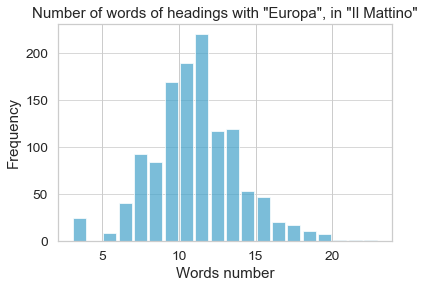

In [398]:
n, bins, patches = plt.hist(x=europe_mat['word_numb'], bins=20, color='#43a2ca',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Words number')
plt.ylabel('Frequency')
plt.title('''Number of words of headings with "Europa", in "Il Mattino"''')
maxfreq = n.max()

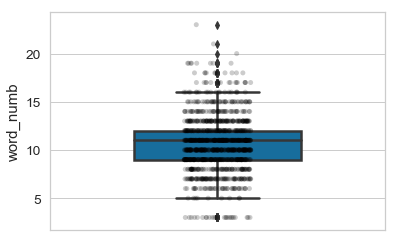

In [399]:
sns.boxplot(y = 'word_numb', 
                 data = europe_mat, 
                 width=0.5,
                 palette="colorblind")
sns.stripplot(y = 'word_numb', 
                   data = europe_mat, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

In [400]:
vectorizer_eu_mat = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 0.99,
                             min_df    = 0.01)

In [401]:
vectorizer_eu_mat.fit(elections_mat['Titles'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=0.01,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ..., 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [402]:
len(vectorizer_eu_mat.get_feature_names())

92

In [403]:
vectorizer_eu_mat.get_feature_names()[0:10]

['10',
 '2019',
 'accedi',
 'addio',
 'amarcord',
 'anni',
 'avellino',
 'avvocati',
 'baby',
 'berlusconi']

In [404]:
frequency_eu_mat = vectorizer_eu_mat.transform(europe_mat['Titles'])

In [405]:
frequency_eu_mat

<1225x92 sparse matrix of type '<class 'numpy.int64'>'
	with 1393 stored elements in Compressed Sparse Row format>

In [406]:
wordfreq_eu_mat = pd.DataFrame(frequency_eu_mat.toarray(),
                            columns = vectorizer_eu_mat.get_feature_names(),
                            index = europe_mat.index)

In [407]:
wordfreq_eu_mat.head()

,10,2019,accedi,addio,amarcord,anni,avellino,avvocati,baby,berlusconi,...,treni,tria,ue,ultimo,venezuela,via,video,voto,weekend,zingaretti
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [408]:
wordfreq_eu_mat.tail()

,10,2019,accedi,addio,amarcord,anni,avellino,avvocati,baby,berlusconi,...,treni,tria,ue,ultimo,venezuela,via,video,voto,weekend,zingaretti
44,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [409]:
wordfreq_eu_mat.sum().sort_values(ascending=False)[:20]

napoli      341
europa       78
italia       73
europee      57
de           51
anni         46
ora          44
salvini      40
governo      38
sud          37
elezioni     37
voto         36
san          30
mattino      26
via          26
accedi       25
ue           24
dopo         24
conte        19
nuovo        18
dtype: int64

In [434]:
df_freq_eu_mat = wordfreq_eu_mat.sum().sort_values(ascending=False)[:20]

In [435]:
pd.DataFrame(df_freq_eu_mat)

,0
napoli,341
europa,78
italia,73
europee,57
de,51
anni,46
ora,44
salvini,40
governo,38
sud,37


In [436]:
df_freq_eu_mat.to_csv('eufreq3.csv')

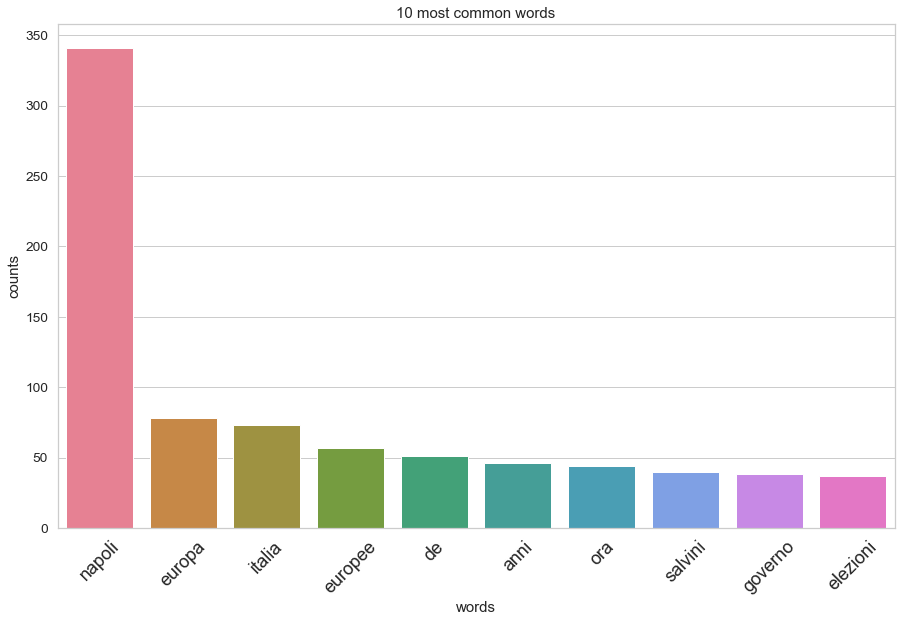

In [410]:
plot_10_most_common_words(frequency_eu_mat, vectorizer_eu_mat)

In [411]:
def best_groups(groups):
    'Looks for the number of groups that gives the best combination of Log Likelihood and Perplexity'
    models = []

    for model in range(1,groups+1):
        lda_model_eu_mat = LatentDirichletAllocation(n_components = model)
        lda_model_eu_mat.fit(frequency_eu_mat)
        loglik = lda_model_eu_mat.score(frequency_eu_mat)
        perpl = lda_model_eu_mat.perplexity(frequency_eu_mat)
        seq = model
        models_dict = {'Log Likelihood': loglik,
                  'Perplexity': perpl,
                  'Groups': seq}
        models.append(models_dict)
    models_df = pd.DataFrame(models)
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Groups')
    models_df.plot.scatter(y = 'Perplexity', x = 'Groups')
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Perplexity')
    return models_df

,Groups,Log Likelihood,Perplexity
0,1,-4938.025855,34.199374
1,2,-5079.715834,37.847285
2,3,-5119.472964,38.939059
3,4,-5086.874860,38.041595
4,5,-5217.031039,41.753441
5,6,-5200.759961,41.270297
6,7,-5310.348201,44.635626
7,8,-5374.675778,46.737476
8,9,-5463.611853,49.807371
9,10,-5392.622599,47.341336


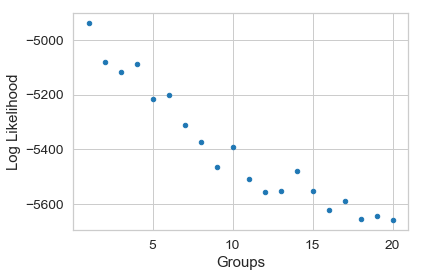

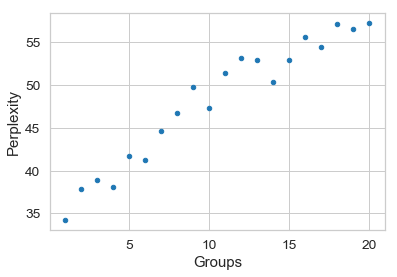

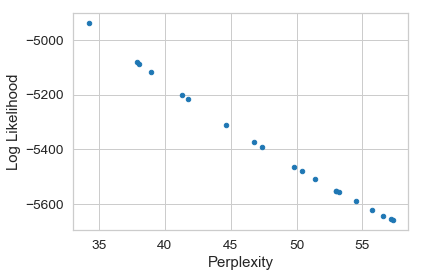

In [412]:
best_groups(20)

In [472]:
lda_model_eu_mat = LatentDirichletAllocation(n_components = 4)

In [473]:
lda_model_eu_mat.fit(frequency_el_mat)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=4, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [474]:
print("Log Likelihood: ", lda_model_eu_mat.score(frequency_eu_mat))

print("Perplexity: ", lda_model_eu_mat.perplexity(frequency_eu_mat))

Log Likelihood:  -6526.447719619703
Perplexity:  106.52903094859319


In [475]:
print(lda_model_eu_mat.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 4, 'n_jobs': None, 'n_topics': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [476]:
pyLDAvis.enable_notebook()
panel_eu_mat = pyLDAvis.sklearn.prepare(lda_model_eu_mat, frequency_eu_mat, vectorizer_eu_mat, mds='tsne')
panel_eu_mat

/Users/federico/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
3     -22.189211 -265.243439       1        1  42.536102
2      34.612003 -151.636261       2        1  23.143032
0      63.015480 -236.840775       3        1  19.969667
1     -50.592365 -180.039490       4        1  14.351200, topic_info=     Category       Freq             Term      Total  loglift  logprob
term                                                                  
29    Default  49.000000         elezioni  49.000000  30.0000  30.0000
14    Default  32.000000        candidati  32.000000  29.0000  29.0000
20    Default  31.000000         comunali  31.000000  28.0000  28.0000
1     Default  30.000000             2019  30.000000  27.0000  27.0000
52    Default  69.000000           napoli  69.000000  26.0000  26.0000
68    Default  33.000000          salvini  33.000000  25.0000  25.0000
43    Default  25.000000            liste  25.000000  24.0000  24.0000
38    Default  30.000000          governo  30.000000  23.0000  23.0000
39    Default  25.000000           italia  25.000000  22.0000  22.0000
46    Default  23.000000             maio  23.000000  21.0000  21.0000
44    Default  22.000000              m5s  22.000000  20.0000  20.0000
41    Default  26.000000             lega  26.000000  19.0000  19.0000
89    Default  39.000000             voto  39.000000  18.0000  18.0000
48    Default  18.000000       mattarella  18.000000  17.0000  17.0000
11    Default  18.000000           brexit  18.000000  16.0000  16.0000
32    Default  56.000000          europee  56.000000  15.0000  15.0000
56    Default  15.000000          omaggio  15.000000  14.0000  14.0000
40    Default  15.000000         italiana  15.000000  13.0000  13.0000
17    Default  15.000000    castellammare  15.000000  12.0000  12.0000
28    Default  15.000000       eccellenza  15.000000  11.0000  11.0000
84    Default  14.000000               ue  14.000000  10.0000  10.0000
37    Default  23.000000           giorno  23.000000   9.0000   9.0000
24    Default  23.000000               de  23.000000   8.0000   8.0000
6     Default  12.000000         avellino  12.000000   7.0000   7.0000
3     Default  22.000000            addio  22.000000   6.0000   6.0000
66    Default  22.000000             resa  22.000000   5.0000   5.0000
50    Default  11.000000              may  11.000000   4.0000   4.0000
72    Default  21.000000            sette  21.000000   3.0000   3.0000
36    Default  11.000000            forza  11.000000   2.0000   2.0000
86    Default  11.000000        venezuela  11.000000   1.0000   1.0000
...       ...        ...              ...        ...      ...      ...
70     Topic4   0.041045         sardegna   3.798004  -2.5862  -8.4945
57     Topic4   0.040864              ora   4.550763  -2.7715  -8.4990
2      Topic4   0.040661           accedi   6.891629  -3.1915  -8.5040
47     Topic4   0.040655  mastroberardino   6.891574  -3.1916  -8.5041
4      Topic4   0.040655         amarcord   6.891574  -3.1916  -8.5041
61     Topic4   0.040655            piero   6.891574  -3.1916  -8.5041
35     Topic4   0.040652            foria   6.891549  -3.1917  -8.5042
30     Topic4   0.040652          ernesto   6.891549  -3.1917  -8.5042
12     Topic4   0.040647            bulle   6.891512  -3.1918  -8.5043
10     Topic4   0.040647       brasiliane   6.891512  -3.1918  -8.5043
58     Topic4   0.040647          origini   6.891512  -3.1918  -8.5043
81     Topic4   0.040647       tredicenne   6.891512  -3.1918  -8.5043
60     Topic4   0.040647        picchiata   6.891512  -3.1918  -8.5043
8      Topic4   0.040648             baby   7.149552  -3.2285  -8.5043
75     Topic4   0.040653         solidale   7.150968  -3.2286  -8.5041
77     Topic4   0.041487           spagna  10.150532  -3.5586  -8.4838
6      Topic4   0.041619         avellino  12.918690  -3.7965  -8.4807
5      Topic4   0.041186             anni  10.899446  -3.6370  -8

In [477]:
topic_words_df(lda_model_eu_mat, vectorizer_eu_mat).head(10)

,0,1,2,3
rank,,,,
1,salvini,elezioni,governo,napoli
2,maio,candidati,italia,europee
3,lega,comunali,mattarella,voto
4,m5s,2019,brexit,giorno
5,elezioni,liste,omaggio,de
6,prima,solo,italiana,addio
7,maggioranza,nuovi,castellammare,resa
8,duello,pronti,eccellenza,pd
9,ultimo,mesi,ue,sette


In [478]:
df_lda_mat = topic_words_df(lda_model_eu_mat, vectorizer_eu_mat).head(10)

In [479]:
pd.DataFrame(df_lda_mat)

,0,1,2,3
rank,,,,
1,salvini,elezioni,governo,napoli
2,maio,candidati,italia,europee
3,lega,comunali,mattarella,voto
4,m5s,2019,brexit,giorno
5,elezioni,liste,omaggio,de
6,prima,solo,italiana,addio
7,maggioranza,nuovi,castellammare,resa
8,duello,pronti,eccellenza,pd
9,ultimo,mesi,ue,sette


In [480]:
df_lda_mat.to_csv('ldamat.csv')

In [419]:
topics_eu_mat = lda_model_eu_mat.transform(frequency_eu_mat)

In [420]:
pd.DataFrame(topics_eu_mat).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.027778,0.027778,0.027778,0.027778,0.694444,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778
1,0.020833,0.270833,0.296836,0.244830,0.020833,0.020833,0.020834,0.020833,0.020833,0.020833,0.020833,0.020833
2,0.020834,0.020833,0.020834,0.436942,0.354723,0.020833,0.020834,0.020833,0.020833,0.020833,0.020833,0.020833
3,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.541666,0.041667,0.041667,0.041667,0.041667
4,0.027778,0.027778,0.027778,0.027778,0.027778,0.361111,0.027778,0.361111,0.027778,0.027778,0.027778,0.027778
5,0.020833,0.020833,0.020833,0.020833,0.020834,0.520833,0.020833,0.270833,0.020833,0.020833,0.020833,0.020833
6,0.041667,0.041667,0.041667,0.041667,0.541667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
7,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.541667,0.041667,0.041667,0.041667,0.041667,0.041667
8,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
9,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.541667,0.041667


In [421]:
europe_mat['Adjectives'] = europe_mat['Titles'].apply(extract_adjectives)

In [422]:
europe_mat['Adjectives']

0                                    AL
1                                      
2                 europee, della, altri
3                            pedagogico
4                                      
5                                      
6                                 della
7                                      
8                                quarto
9                                      
10                                     
11                      muscolare, sola
12                                     
13                               finale
14    Primo, generale, aragonese, nuovo
15                                     
16                                super
17                        ultimo, primo
18                             migranti
19                              azzurra
20           falsi, logistica, algerini
21                              europee
22                                     
23                        umano, ultima
24                                     


In [423]:
vectorizer_eu_mat2 = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 1.0,
                             min_df    = 0.0)

In [424]:
vectorizer_eu_mat2.fit(europe_mat['Adjectives'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ..., 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [425]:
wf_eu_mat = vectorizer_eu_mat2.transform(europe_mat['Adjectives'])

In [426]:
df_eu_mat = pd.DataFrame(wf_eu_mat.todense(),
                        columns = vectorizer_eu_mat2.get_feature_names())

In [427]:
df_eu_mat.sum().sort_values(ascending=False)

napoletani    28
europeo       26
aperte        25
nuovo         18
primo         18
europee       17
grande         9
nuova          9
politica       8
arsenal        8
prima          8
ex             7
migranti       7
secondo        6
ultima         5
europea        5
nuove          5
primi          5
nuovi          5
pronto         5
nera           5
giovani        5
italiano       5
anti           5
possibile      4
alta           4
azzurri        4
pari           4
altra          4
nazionale      4
              ..
rammarico      1
rapito         1
rarissima      1
regionale      1
regionali      1
residenti      1
positivo       1
positiva       1
portuale       1
popolari       1
ottimo         1
pacifico       1
palazzetto     1
parli          1
pazza          1
pazze          1
pedagogico     1
perfetto       1
pericolose     1
personale      1
piccole        1
piccoli        1
piccolo        1
pieno          1
pizzerie       1
plastica       1
polari         1
polemico      

In [487]:
df_adjmat = df_eu_mat.sum().sort_values(ascending=False)

In [488]:
pd.DataFrame(df_adjmat)

,0
napoletani,28
europeo,26
aperte,25
nuovo,18
primo,18
europee,17
grande,9
nuova,9
politica,8
arsenal,8


In [489]:
df_adjmat.to_csv('eu_adjmat.csv')